# Classifying Strokes with Machine Learning Models

## Exploratory Data Analysis (EDA) and Preprocessing

In [9]:
# import
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, f1_score, recall_score, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from collections import Counter

# Create dictionary of classifiers with their specific SMOTE ratios
base_estimator = DecisionTreeClassifier(max_depth=3, random_state=42)
classifier_configs = {
    'KNN': {'model': KNeighborsClassifier(n_neighbors=1), 'smote_ratio': 14},
    'Bagging': {'model': BaggingClassifier(random_state=42), 'smote_ratio': 12},
    'Random Forest': {'model': RandomForestClassifier(random_state=42), 'smote_ratio': 11},
    'Decision Tree': {'model': DecisionTreeClassifier(random_state=42), 'smote_ratio': 11},
    'SVM': {'model': SVC(probability=True), 'smote_ratio': 1},
    'AdaBoost': {'model': AdaBoostClassifier(base_estimator, n_estimators=100, learning_rate=1.0, algorithm='SAMME', random_state=42), 'smote_ratio': 1},
    'Naive Bayes': {'model': GaussianNB(), 'smote_ratio': 1},
    'Logistic Regression': {'model': LogisticRegression(random_state=42), 'smote_ratio': 1}
}

In [10]:
# 1. Load the dataset
data = pd.read_csv("healthcare-dataset-stroke-data.csv")

=== Visualization after encoding categorical variables ===


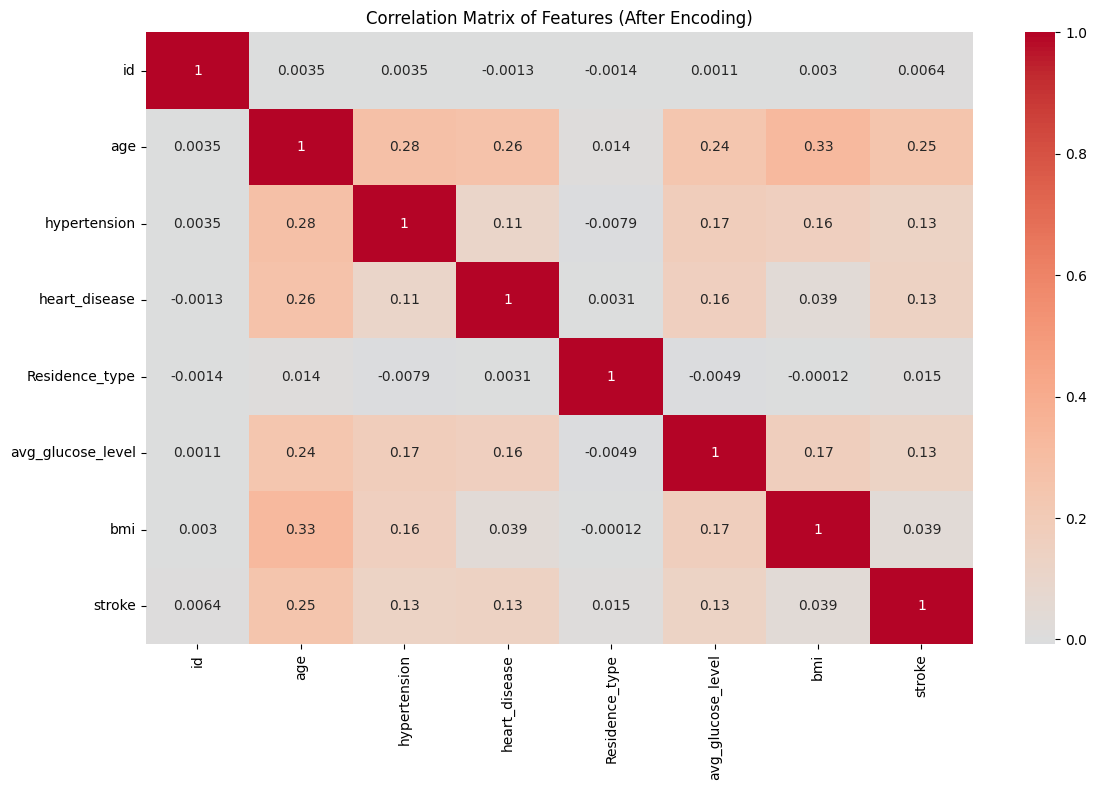


Absolute counts:
stroke
0    4861
1     249
Name: count, dtype: int64

=== Visualization after creating new features ===


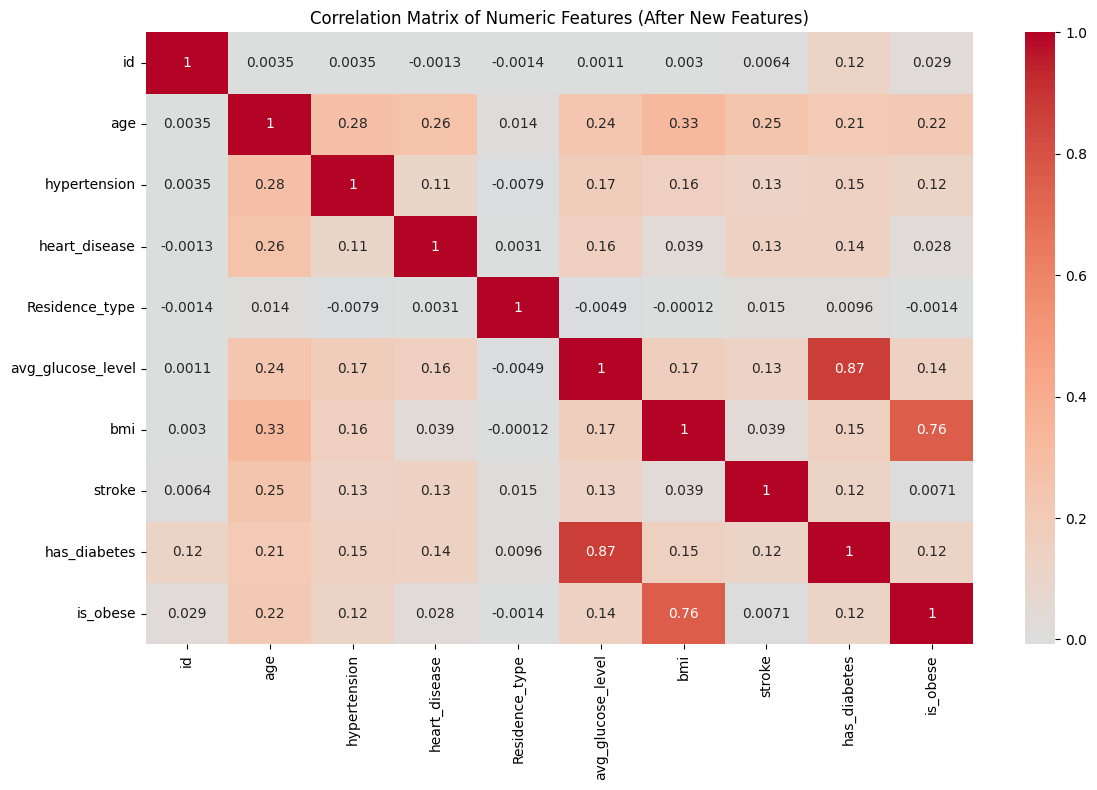

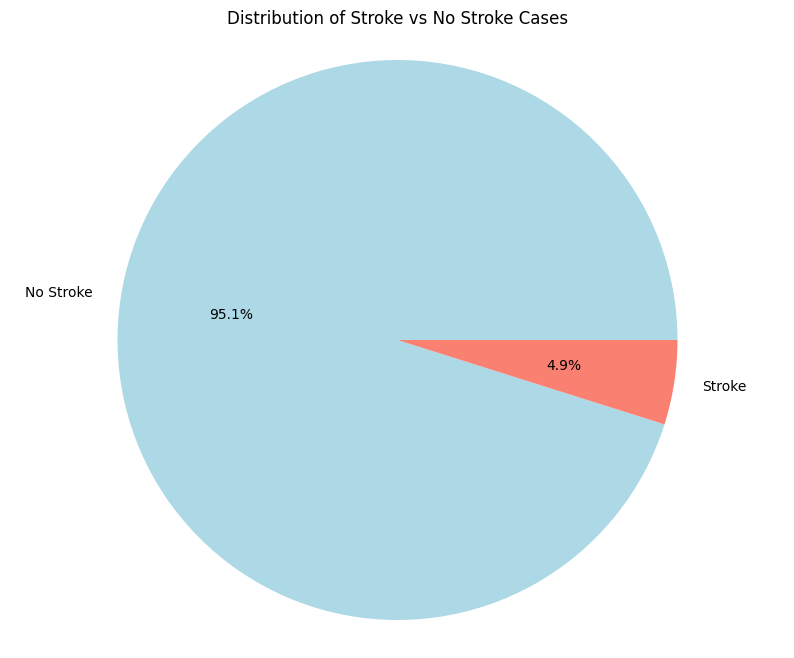


Absolute counts:
stroke
0    4861
1     249
Name: count, dtype: int64


In [11]:
# 2. Preprocess and visualize the data
# First handle missing values and encode categorical variables
data['bmi'] = data['bmi'].fillna(data['bmi'].mean())
data['work_type'] = data['work_type'].map({'children': 0, 'Govt_job': 1, 'Never_worked':2,'Private':3, 'Self-employed':4,})
data['Residence_type'] = data['Residence_type'].map({'Rural': 0, 'Urban': 1})
data['smoking_status'] = data['smoking_status'].map({'formerly smoked': 0, 'never smoked': 1, 'smokes': 2, 'Unknown': 3})
data = pd.get_dummies(data, columns=['work_type', 'smoking_status'], drop_first=True)

# Visualization 1: After encoding categorical variables
print("=== Visualization after encoding categorical variables ===")
# Correlation Matrix
plt.figure(figsize=(12, 8))
numeric_cols = data.select_dtypes(include=[np.number]).columns
correlation_matrix = data[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Features (After Encoding)')
plt.tight_layout()
plt.show()

print("\nAbsolute counts:")
print(stroke_counts)

# Create new features has_diabetes and is_obese
data['has_diabetes'] = (data['avg_glucose_level'] > 126).astype(int)
data['is_obese'] = (data['bmi'] > 30).astype(int)

# Visualization 2: After creating new features
print("\n=== Visualization after creating new features ===")
# Updated Correlation Matrix
plt.figure(figsize=(12, 8))
numeric_cols = data.select_dtypes(include=[np.number]).columns
correlation_matrix = data[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numeric Features (After New Features)')
plt.tight_layout()
plt.show()

# Updated Pie Chart (this will be the same as before feature creation since stroke distribution hasn't changed)
plt.figure(figsize=(10, 8))
stroke_counts = data['stroke'].value_counts()
colors = ['lightblue', 'salmon']
plt.pie(stroke_counts, labels=['No Stroke', 'Stroke'], autopct='%1.1f%%', colors=colors)
plt.title('Distribution of Stroke vs No Stroke Cases')
plt.axis('equal')
plt.show()

print("\nAbsolute counts:")
print(stroke_counts)

In [ ]:
# 3. Define features and target
features_to_drop = ['id', 'stroke', 'gender', 'ever_married']
X = data.drop(features_to_drop, axis=1)
y = data['stroke']

X_original = data.drop(features_to_drop, axis=1)
y_original = data['stroke']

# Split original dataset to obtain the original test set
_, X_test_original, _, y_test_original = train_test_split(X_original, y_original, test_size=0.2, random_state=42)

#### Analysis and Discussion of the dataset
Upon looking at the dataset, we discovered categorical data for the work_type, residence_type, and smoking_status. We also discovered through errors when testing the code that bmi had missing values. To address these problems, we have encoded the categorical values as numeric values, and we have also filled in missing values. When filling in the missing values for bmi, we used the pandas module function 'fillna()' to fill NaN (missing) values. We filled the missing values using the mean that calculates the average of all non-missing bmi values.

Upon reading other research papers, we came across a paper by Al-Mekhlafi et al. titled "[Deep Learning and Machine Learning for Early Detection of Stroke and Haemorrhage](https://www.proquest.com/docview/2691783314?pq-origsite=primo&sourcetype=Scholarly%20Journals)." When reading this paper, we found that in their stroke classification, they created new features is_obese and has_diabetes based on the existing data in the dataset. Further researching from [Mayo Clinic](https://www.mayoclinic.org/diseases-conditions/stroke/symptoms-causes/syc-20350113) and [American Stroke Association](https://www.stroke.org/en/about-stroke/stroke-risk-factors), we found that these are leading contributors to strokes, so it makes sense to create these features from the existing data in the dataset. Also from the paper by Al-Mekhlafi et al., we found that it may be beneficial to exclude gender and ever_married, so we compared the results from before and after exclusing these features and we found the removal to beneficial.

Looking at the pie chart that visualizes the data of datapoints with strokes and datapoints without strokes, we can see the distribution is very imbalanced. 95.1% of the datapoints did not have a stroke, whereas 4.9% of the datapoints did have a stroke. To address this problem, we have used SMOTE for data augmentation as shown below.

## Visualization and Testing of models with numerous SMOTE ratios


Performing SMOTE ratio analysis for KNN...
10 models complete. 20 models complete. 30 models complete. 

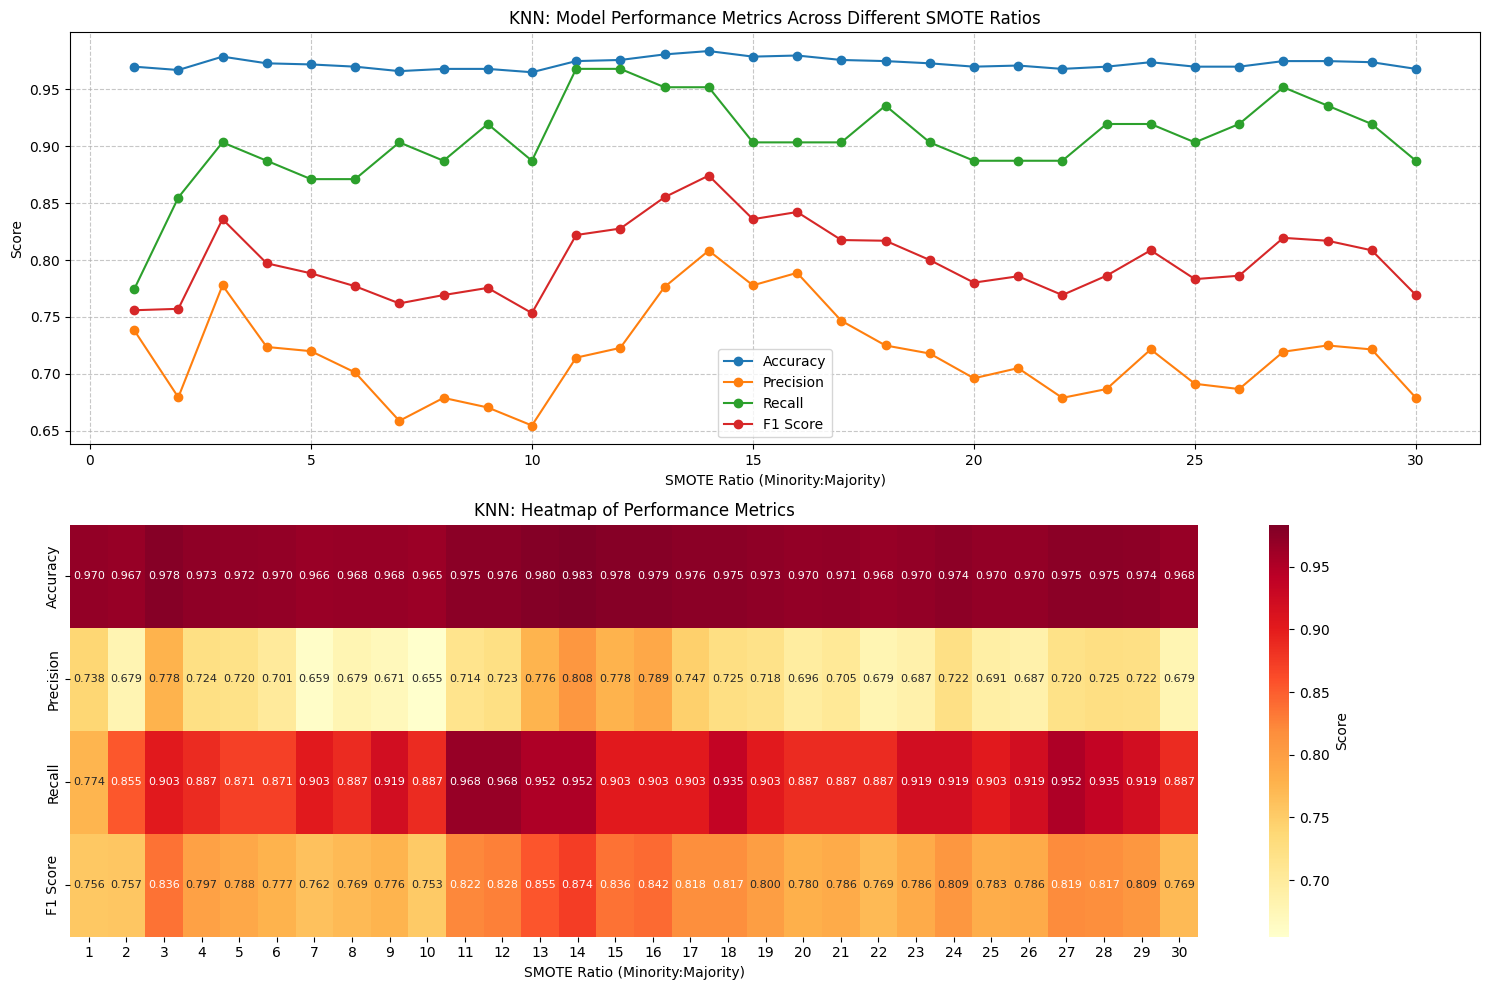


Best SMOTE Ratios for KNN:
Accuracy: Ratio 14:1 (Score: 0.983)
Precision: Ratio 14:1 (Score: 0.808)
Recall: Ratio 11:1 (Score: 0.968)
F1 Score: Ratio 14:1 (Score: 0.874)



Performing SMOTE ratio analysis for Bagging...
10 models complete. 20 models complete. 30 models complete. 

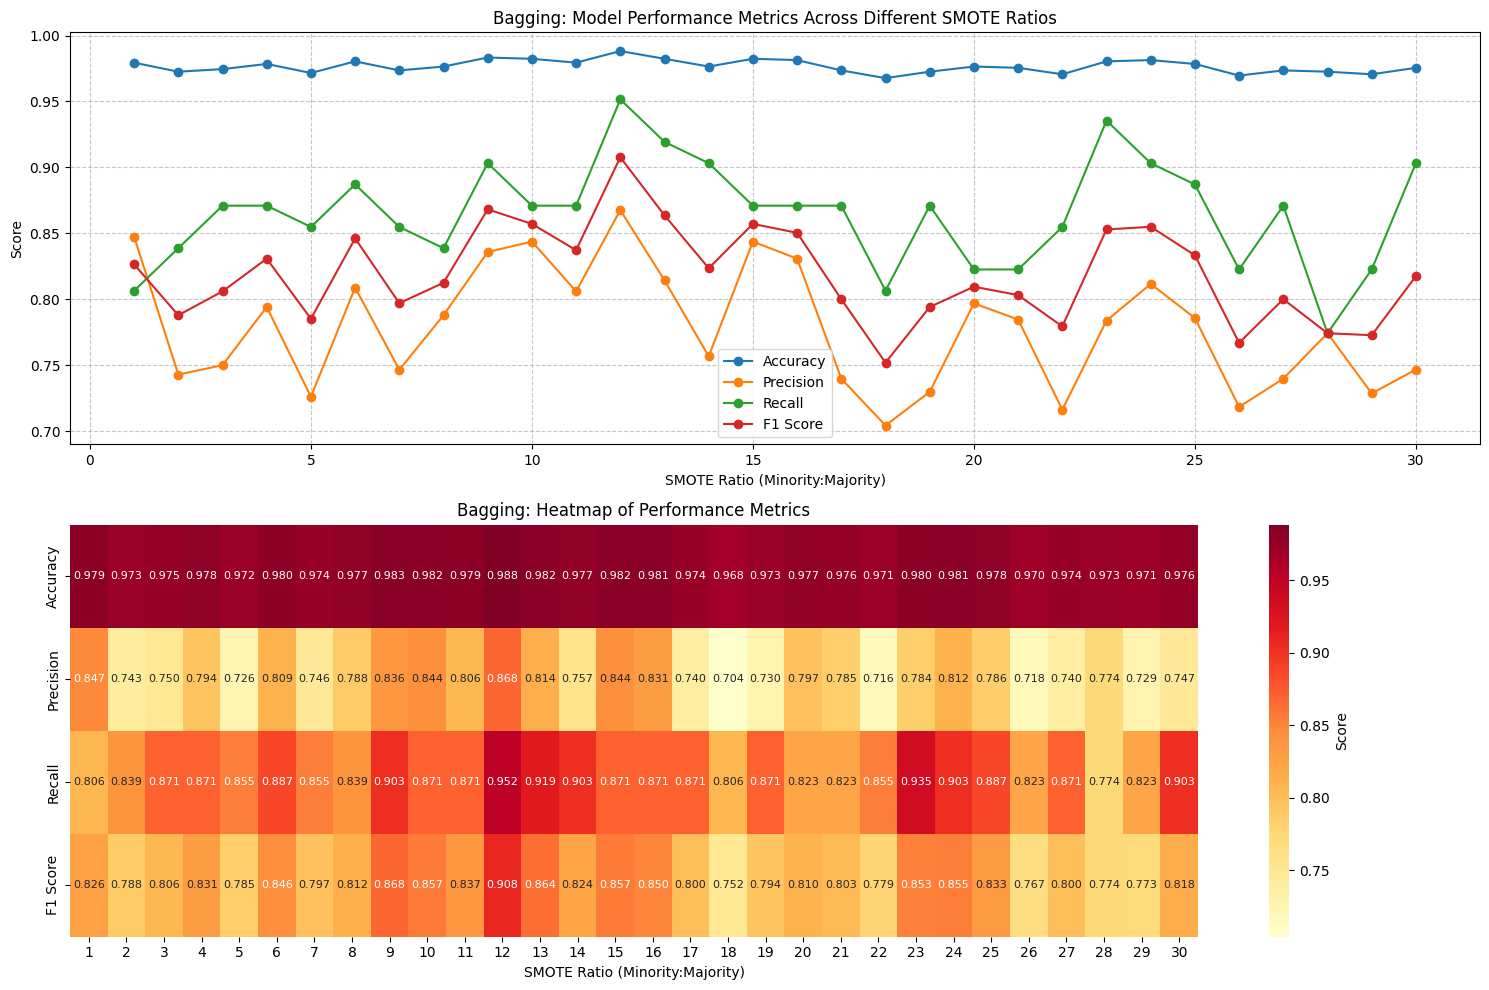


Best SMOTE Ratios for Bagging:
Accuracy: Ratio 12:1 (Score: 0.988)
Precision: Ratio 12:1 (Score: 0.868)
Recall: Ratio 12:1 (Score: 0.952)
F1 Score: Ratio 12:1 (Score: 0.908)



Performing SMOTE ratio analysis for Random Forest...
10 models complete. 20 models complete. 30 models complete. 

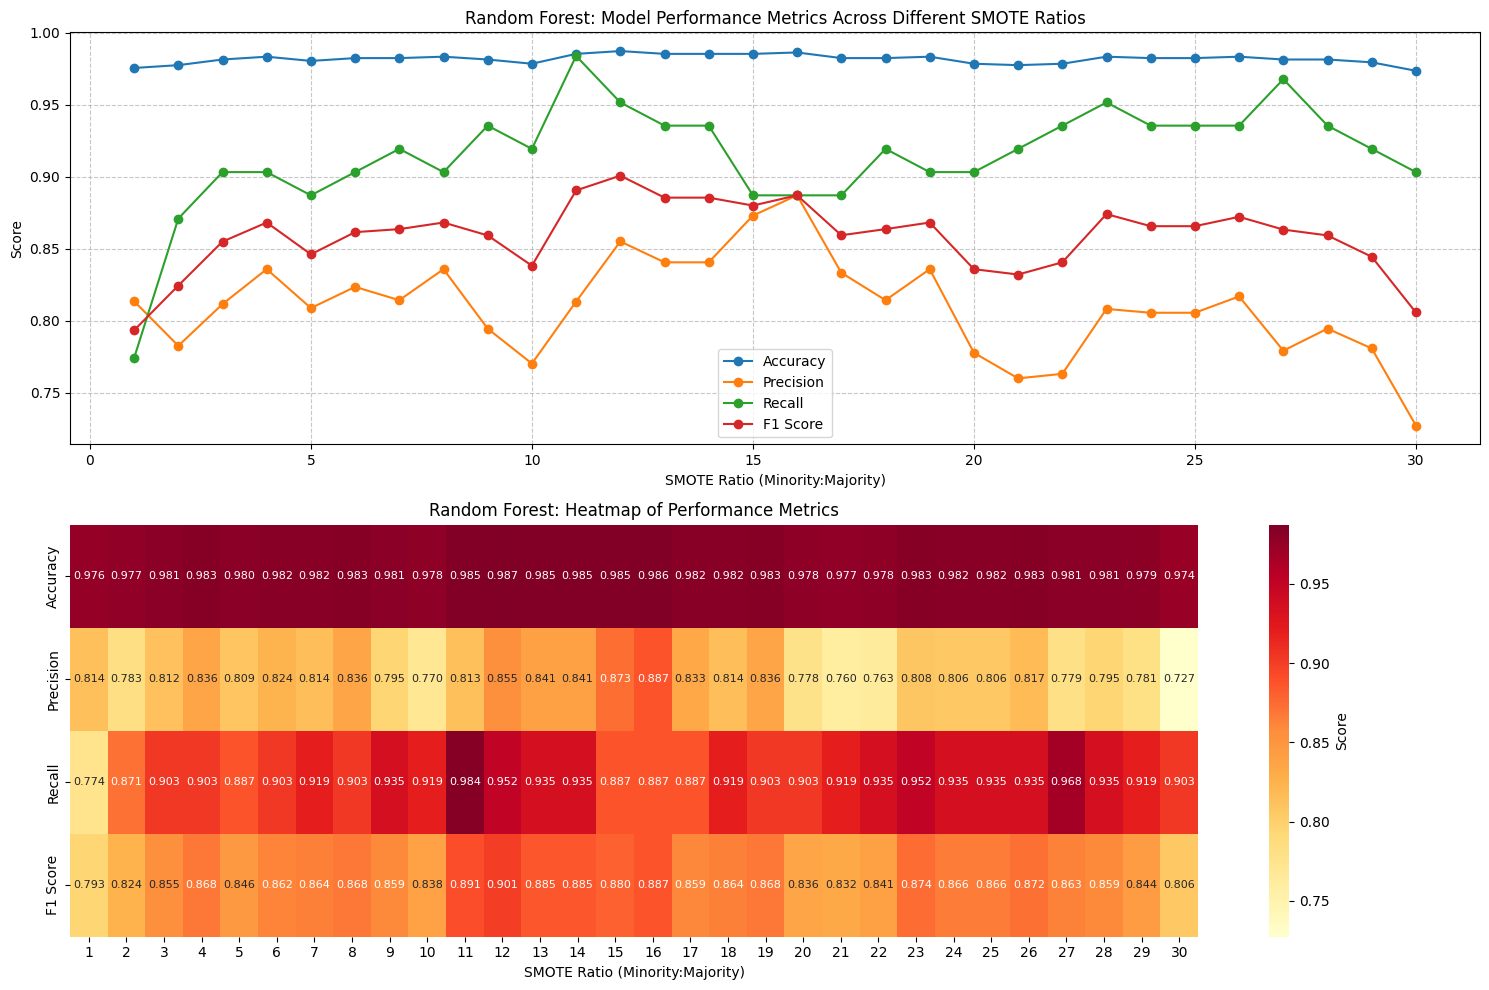


Best SMOTE Ratios for Random Forest:
Accuracy: Ratio 12:1 (Score: 0.987)
Precision: Ratio 16:1 (Score: 0.887)
Recall: Ratio 11:1 (Score: 0.984)
F1 Score: Ratio 12:1 (Score: 0.901)



Performing SMOTE ratio analysis for Decision Tree...
10 models complete. 20 models complete. 30 models complete. 

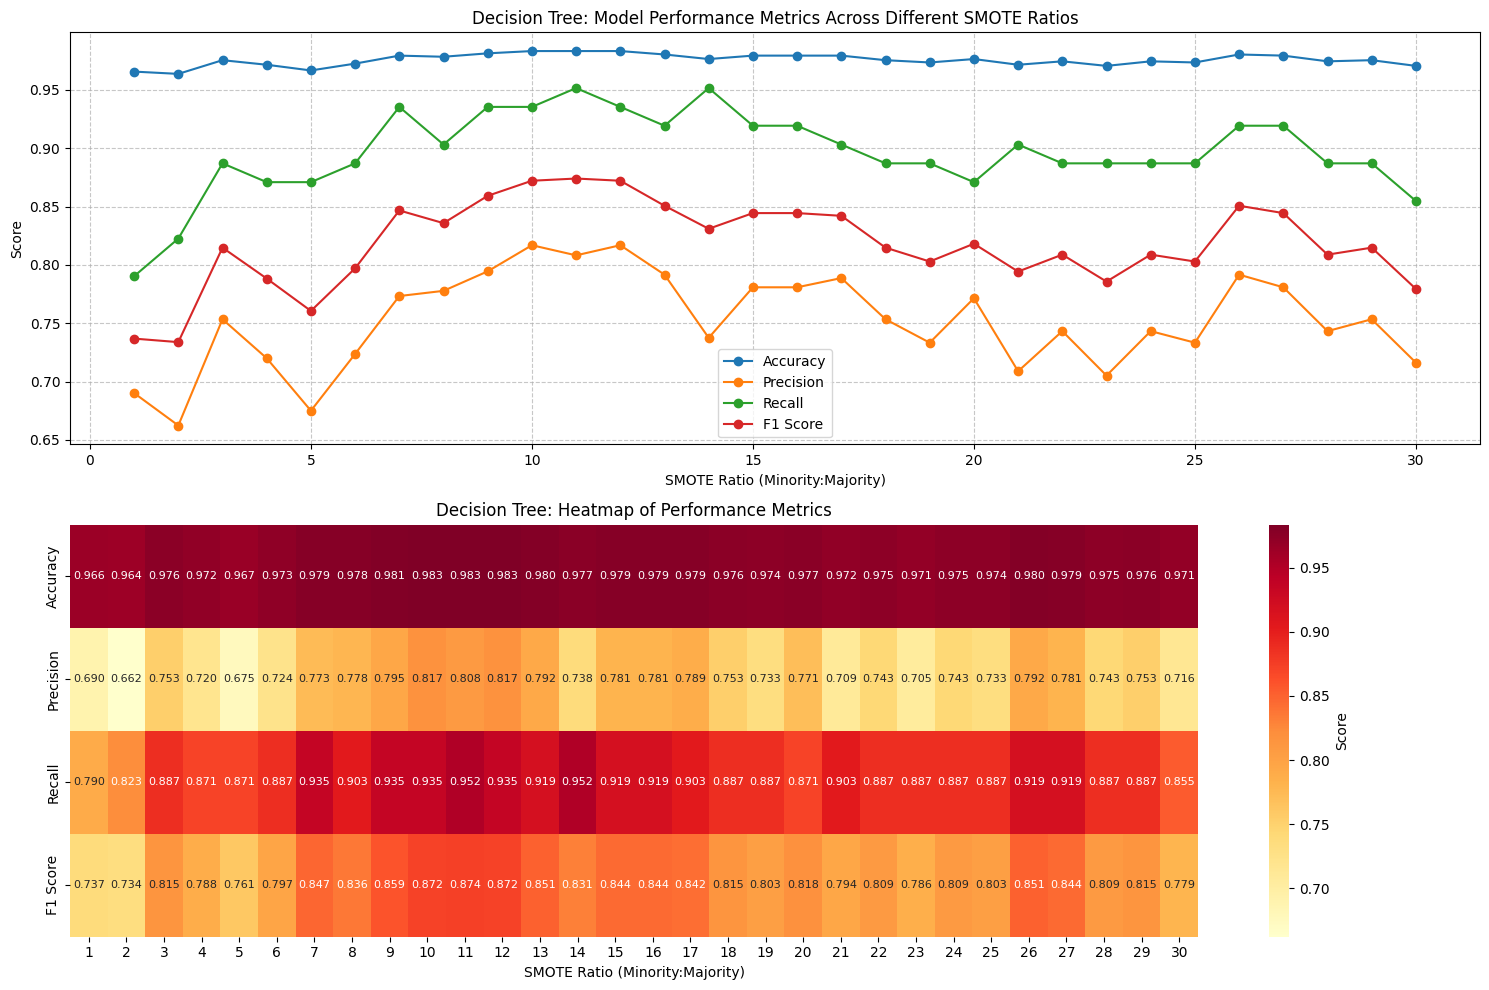


Best SMOTE Ratios for Decision Tree:
Accuracy: Ratio 10:1 (Score: 0.983)
Precision: Ratio 10:1 (Score: 0.817)
Recall: Ratio 11:1 (Score: 0.952)
F1 Score: Ratio 11:1 (Score: 0.874)



Performing SMOTE ratio analysis for SVM...
10 models complete. 20 models complete. 

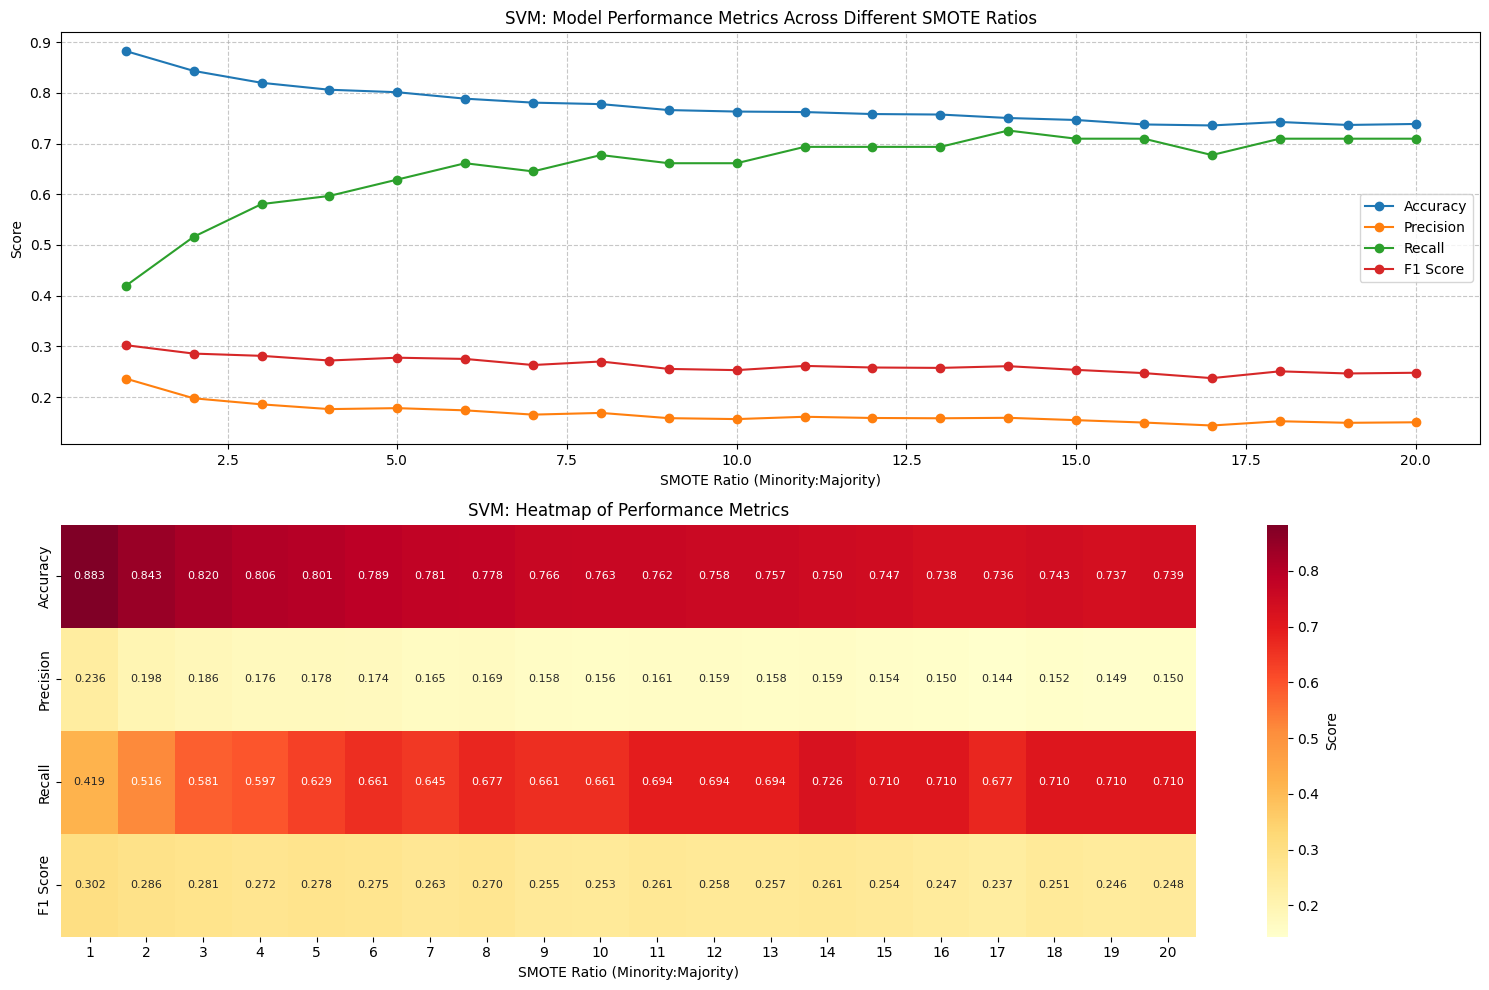


Best SMOTE Ratios for SVM:
Accuracy: Ratio 1:1 (Score: 0.883)
Precision: Ratio 1:1 (Score: 0.236)
Recall: Ratio 14:1 (Score: 0.726)
F1 Score: Ratio 1:1 (Score: 0.302)



Performing SMOTE ratio analysis for AdaBoost...
10 models complete. 20 models complete. 30 models complete. 

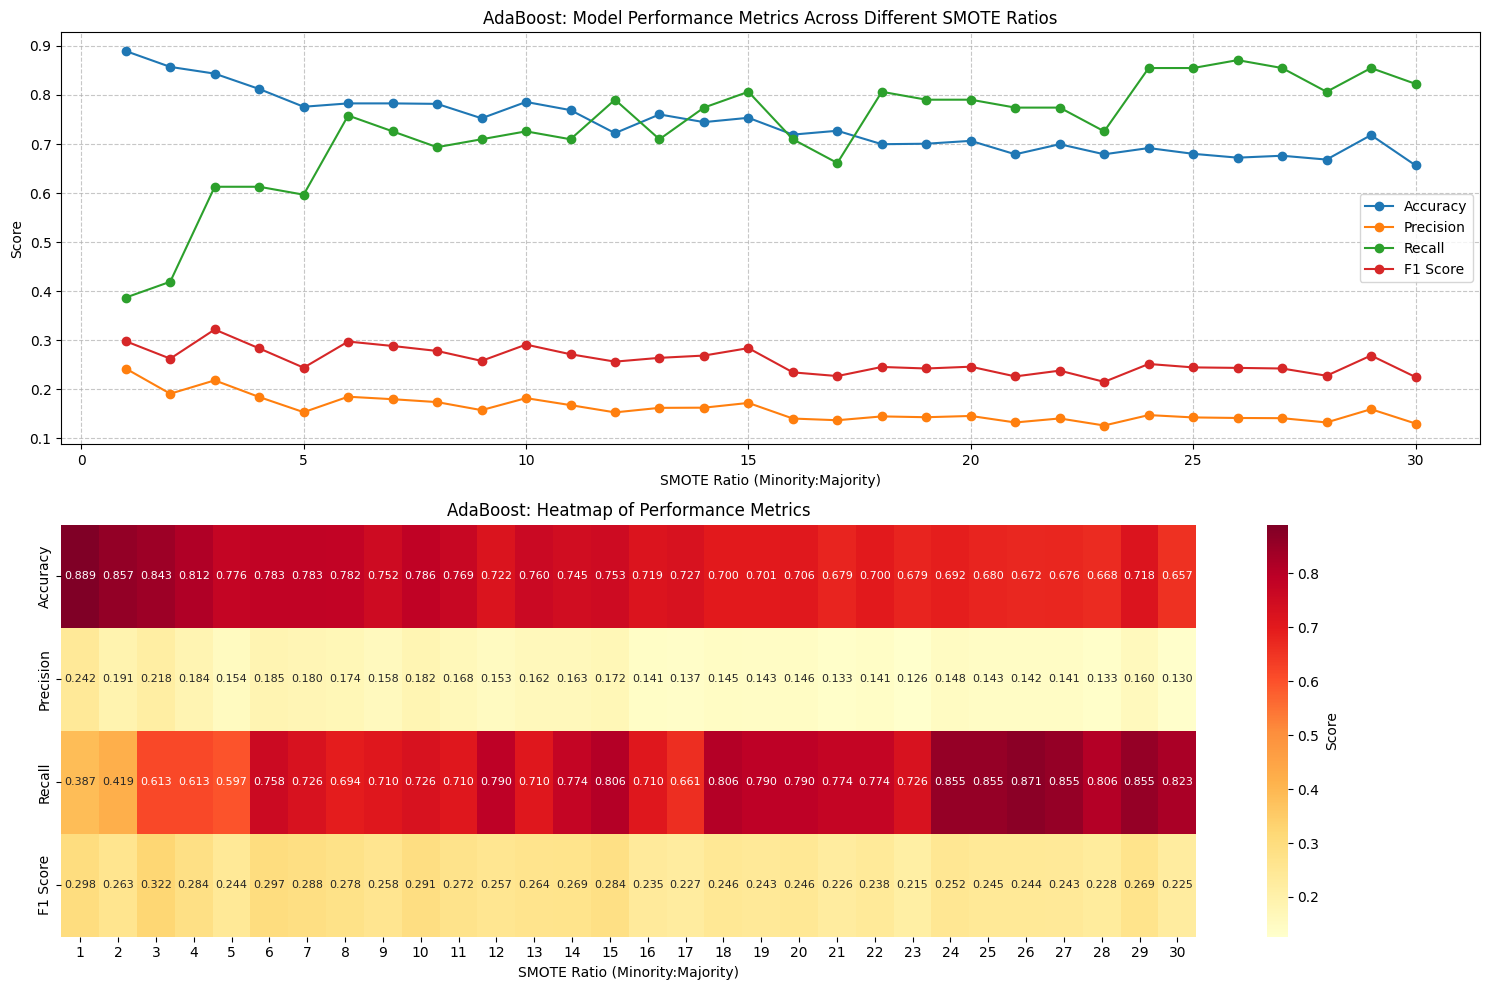


Best SMOTE Ratios for AdaBoost:
Accuracy: Ratio 1:1 (Score: 0.889)
Precision: Ratio 1:1 (Score: 0.242)
Recall: Ratio 26:1 (Score: 0.871)
F1 Score: Ratio 3:1 (Score: 0.322)



Performing SMOTE ratio analysis for Naive Bayes...
10 models complete. 20 models complete. 30 models complete. 

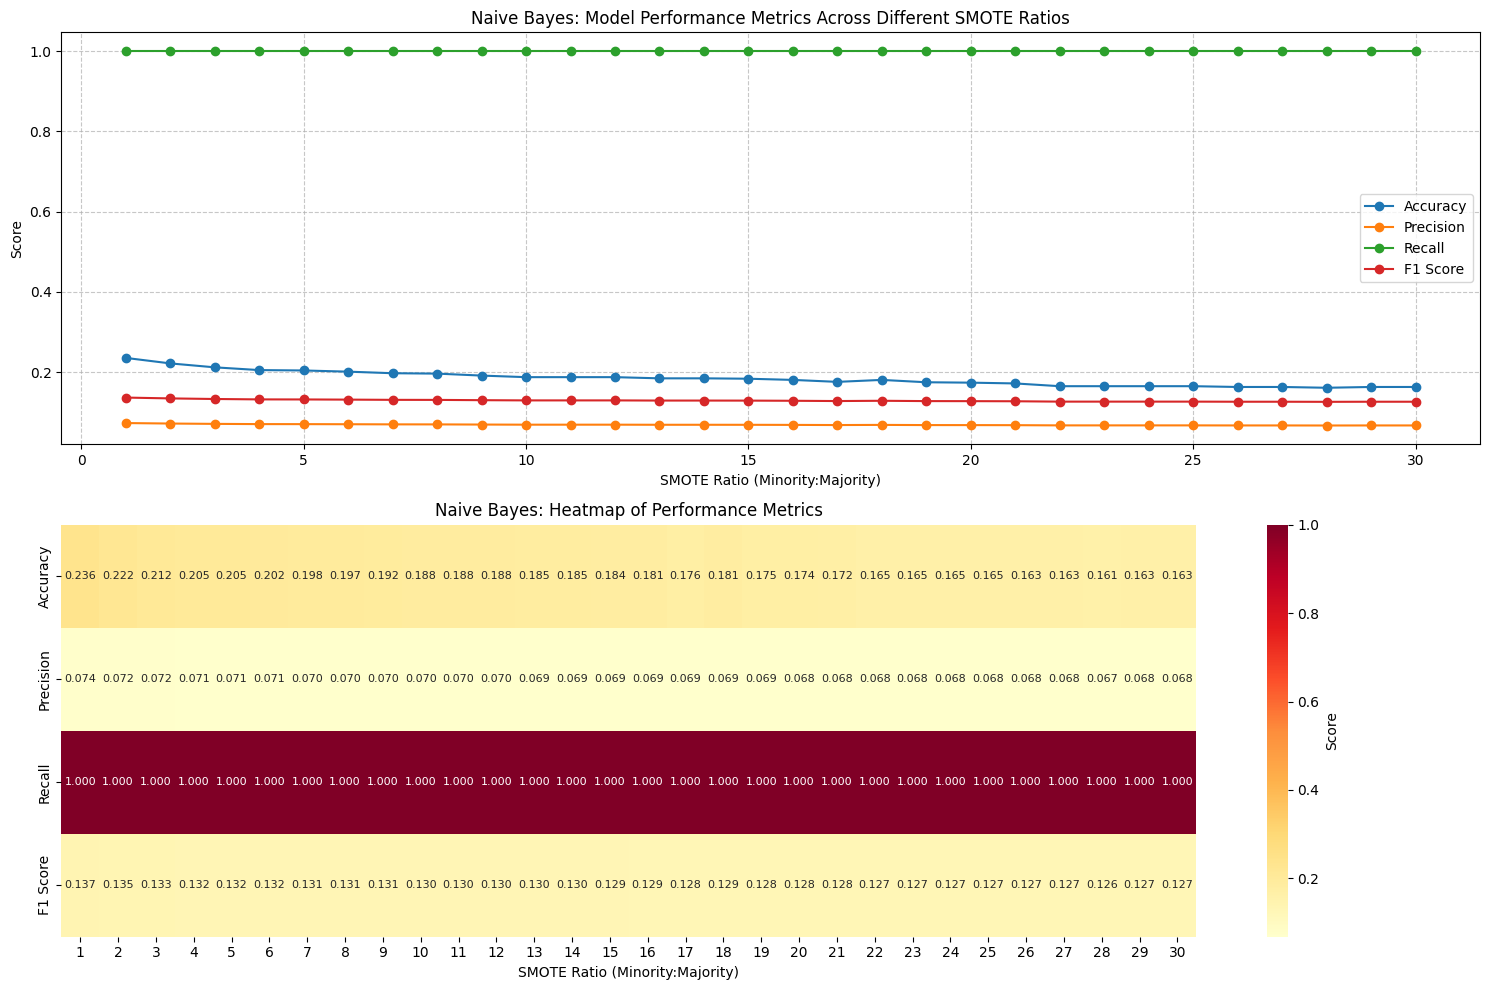


Best SMOTE Ratios for Naive Bayes:
Accuracy: Ratio 1:1 (Score: 0.236)
Precision: Ratio 1:1 (Score: 0.074)
Recall: Ratio 1:1 (Score: 1.000)
F1 Score: Ratio 1:1 (Score: 0.137)



Performing SMOTE ratio analysis for Logistic Regression...
10 models complete. 20 models complete. 30 models complete. 

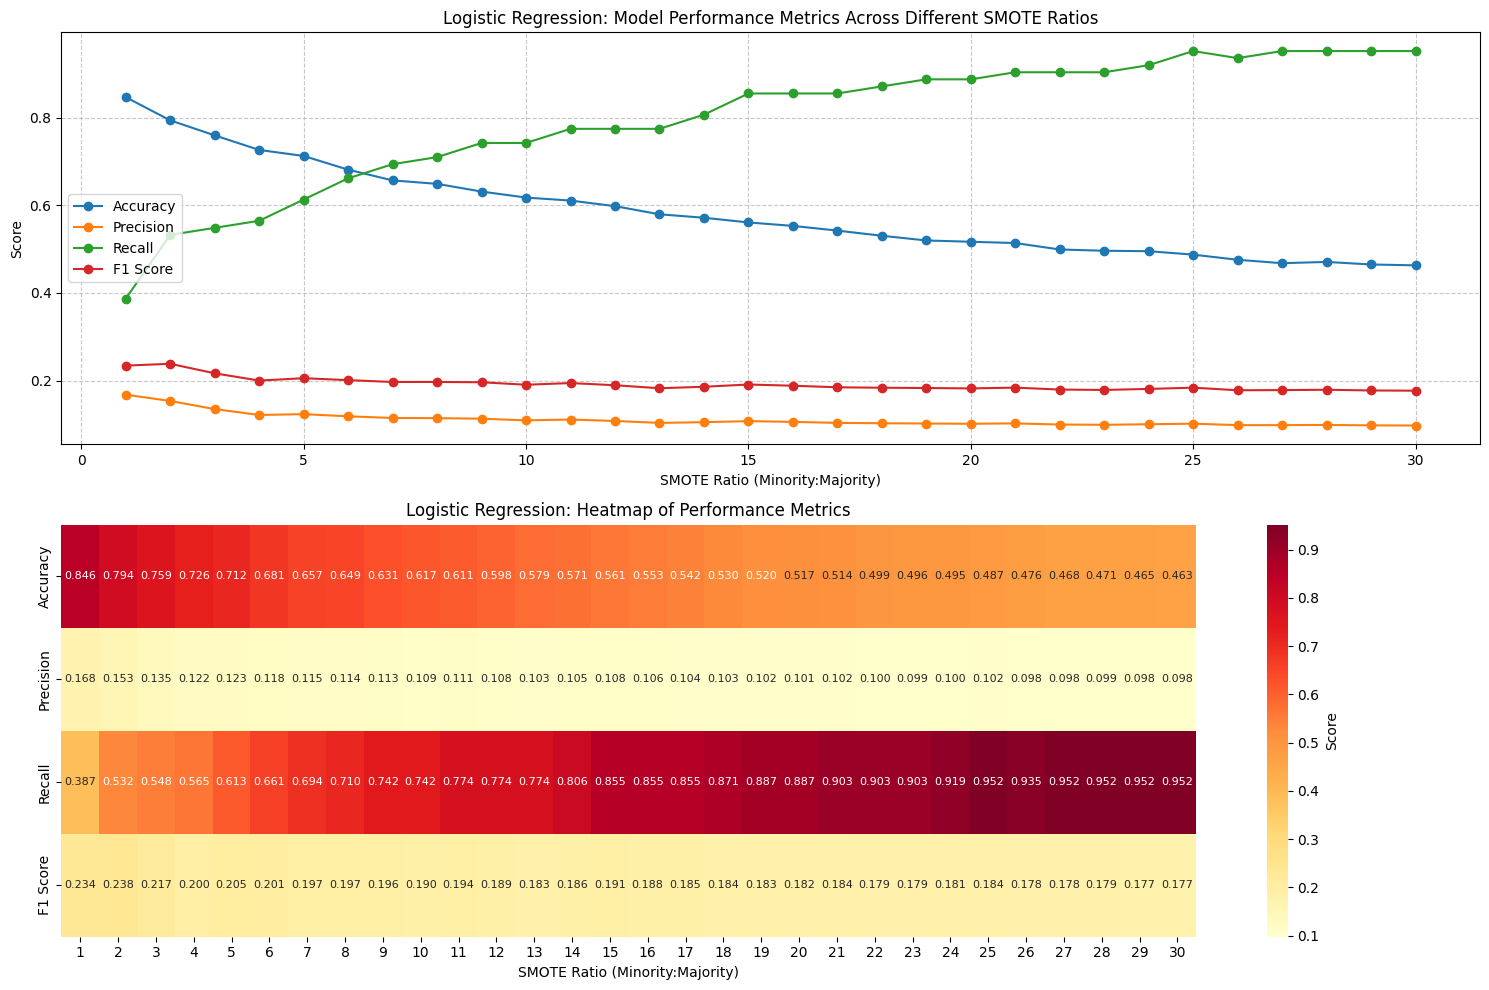


Best SMOTE Ratios for Logistic Regression:
Accuracy: Ratio 1:1 (Score: 0.846)
Precision: Ratio 1:1 (Score: 0.168)
Recall: Ratio 25:1 (Score: 0.952)
F1 Score: Ratio 2:1 (Score: 0.238)




In [5]:
# 4. Visualize results for different SMOTE ratios
# Perform SMOTE ratio analysis for each classifier
for name, config in classifier_configs.items():
    print(f"\n{'='*50}")
    print(f"Performing SMOTE ratio analysis for {name}...")
    print(f"{'='*50}")

    # Collect metrics for different SMOTE ratios
    ratios = list(range(1,31))
    if name == 'SVM':
        ratios = list(range(1,21))
    results = {
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1 Score': []
    }

    for ratio in ratios:
        # Apply SMOTE with different ratios
        smote = SMOTE(sampling_strategy={0: len(y[y==0]), 1: ratio*len(y[y==0])}, random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X, y)

        # Train model on resampled data
        X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(
            X_resampled, y_resampled, test_size=0.2, random_state=42)

        scaler = StandardScaler()
        X_train_resampled = scaler.fit_transform(X_train_resampled)
        X_test_original_scaled = scaler.transform(X_test_original)

        # Train model and predict on original test data
        classifier = config['model']
        classifier.fit(X_train_resampled, y_train_resampled)
        y_pred_original = classifier.predict(X_test_original_scaled)

        # Calculate metrics using original test data
        results['Accuracy'].append(accuracy_score(y_test_original, y_pred_original))
        results['Precision'].append(precision_score(y_test_original, y_pred_original))
        results['Recall'].append(recall_score(y_test_original, y_pred_original))
        results['F1 Score'].append(f1_score(y_test_original, y_pred_original))

        if ratio % 10 == 0:
            print(f"{ratio} models complete. ", end="")
        
    # Create figure for SMOTE analysis
    plt.figure(figsize=(15, 10))
    
    # Line plot
    plt.subplot(2, 1, 1)
    for metric in results.keys():
        plt.plot(ratios, results[metric], marker='o', label=metric)
    plt.xlabel('SMOTE Ratio (Minority:Majority)')
    plt.ylabel('Score')
    plt.title(f'{name}: Model Performance Metrics Across Different SMOTE Ratios')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    # Heatmap
    plt.subplot(2, 1, 2)
    heatmap_data = np.array([results[metric][:30] for metric in results.keys()])
    sns.heatmap(heatmap_data, 
                annot=True,
                fmt='.3f',
                xticklabels=ratios,
                yticklabels=results.keys(),
                cmap='YlOrRd',
                annot_kws={'size': 8},
                cbar_kws={'label': 'Score'})
    plt.xlabel('SMOTE Ratio (Minority:Majority)')
    plt.title(f'{name}: Heatmap of Performance Metrics')
    
    plt.tight_layout()
    plt.show()

    # Print the best ratio for each metric
    print(f"\nBest SMOTE Ratios for {name}:")
    for metric in results.keys():
        best_ratio = ratios[np.argmax(results[metric])]
        best_score = max(results[metric])
        print(f"{metric}: Ratio {best_ratio}:1 (Score: {best_score:.3f})")
    
    print("\n")

#### Analysis and Decisions from SMOTE ratio tests visualizations above
We analyzed and tested different SMOTE data augmentation ratios for our models. Each time a SMOTE ratio is used, it augments the data so that there are a number of datapoints that contain a stroke that is a multiple of the non-stroke datapoints. For example, when it is said that the ratio is 2:1, this means that there are twice as many datapoints that contain a stroke than there are datapoints that do not contain a stroke, so if there are 100 datapoints without a stroke, then there are 200 datapoints that contain a stroke.

Based on the tests and visualizations above, we came to the following conclusions and made the following choices:
1) **KNN** had the highest accuracy with a SMOTE ratio of 14:1, so we chose this ratio.
2) **Bagging** had the highest accuracy with a SMOTE ratio of 12:1, so we chose this ratio.
3) **Random Forest** had the highest accuracy with a SMOTE ratio of 12:1, but we chose a SMOTE ratio of 11:1 because this ratio has a better recall and less false negatives than a ratio of 12:1 while only sacrificing about 0.2% accuracy.
4) **Decision Tree** had the highest accuracy with a SMOTE ratio of 10:1, so we chose this ratio.
5) **SVM** had the highest accuracy with a SMOTE ratio of 1:1, so we chose this ratio.
6) **AdaBoost** had the highest accuracy with a SMOTE ratio of 1:1, so we chose this ratio.
7) **Naive Bayes** had the highest accuracy with a SMOTE ratio of 1:1, so we chose this ratio.
8) **Logistic Regression** had the highest accuracy with a SMOTE ratio of 1:1, so we chose this ratio. 

## Analyzing Performance of the Models with the Best-Fit SMOTE ratios


Analyzing KNN with SMOTE ratio 14:1


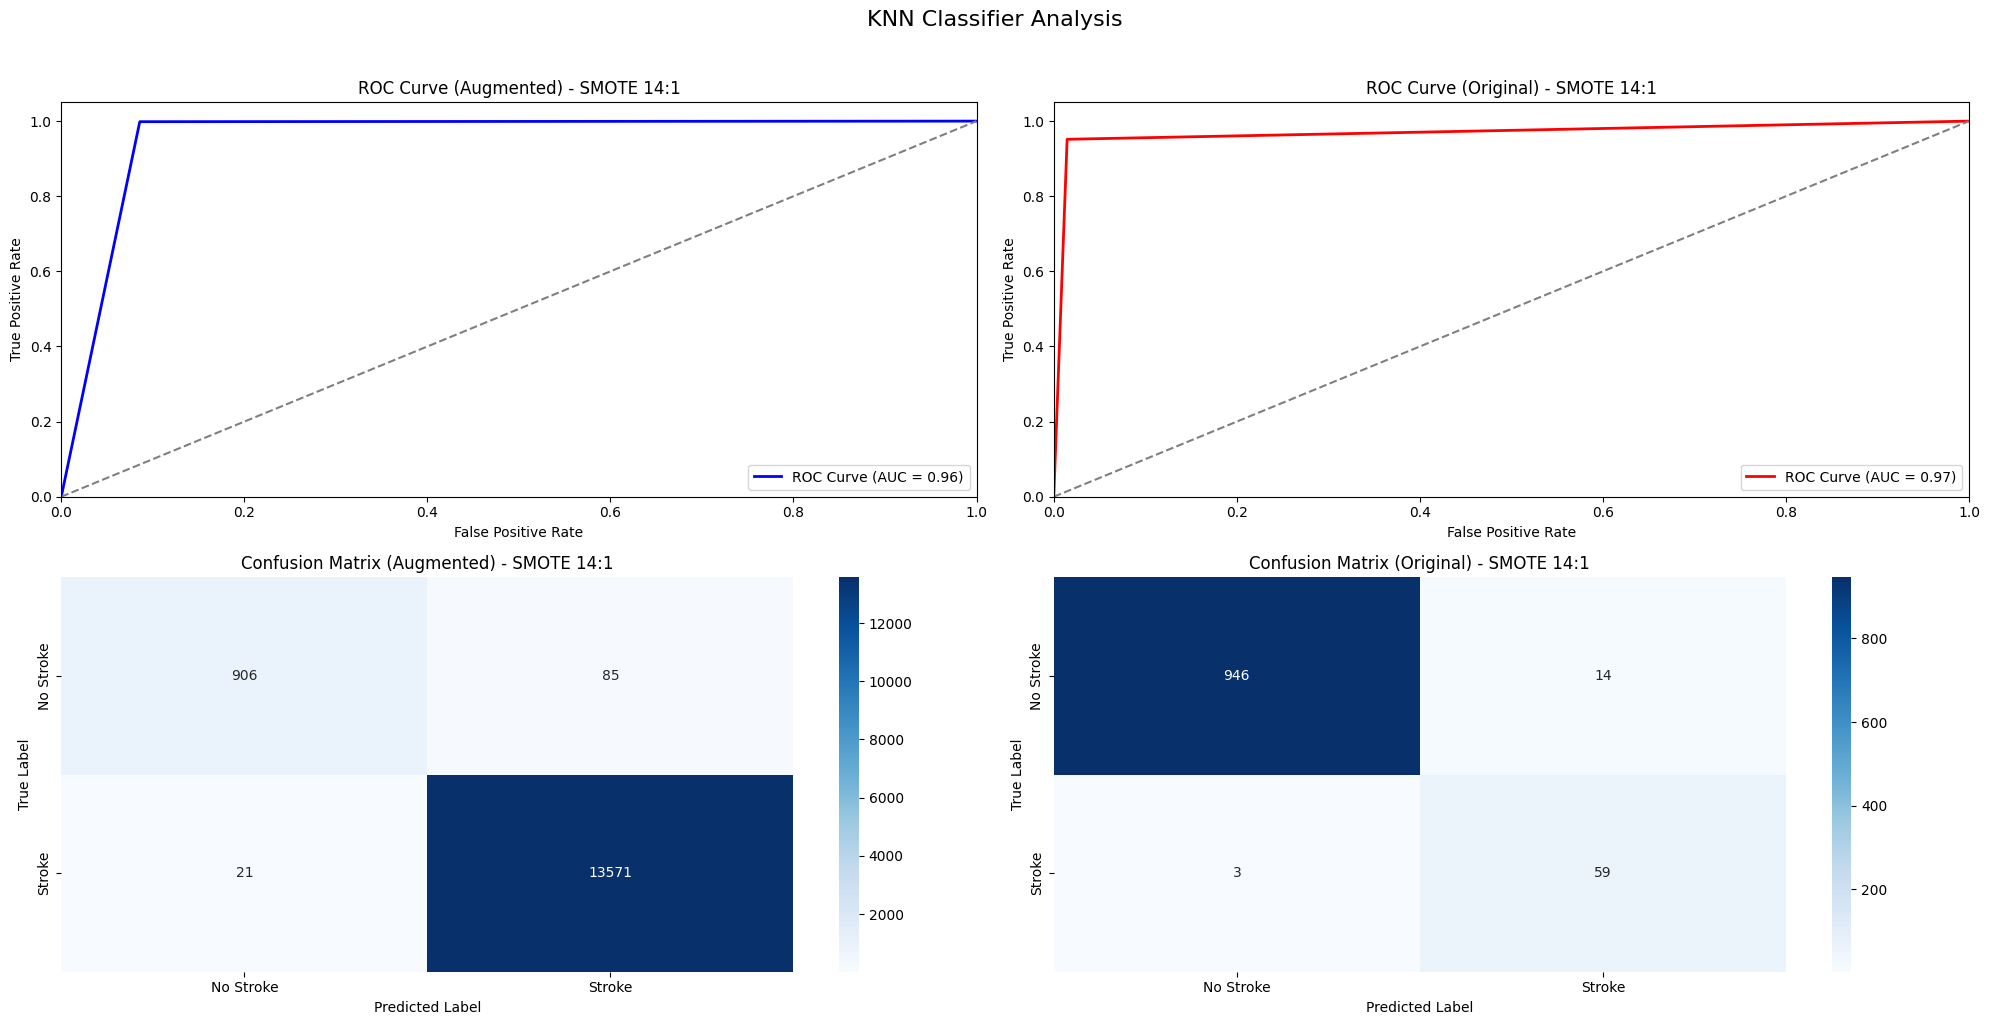


Augmented Test Data:
Accuracy: 0.9927312624288556
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.91      0.94       991
           1       0.99      1.00      1.00     13592

    accuracy                           0.99     14583
   macro avg       0.99      0.96      0.97     14583
weighted avg       0.99      0.99      0.99     14583


Original Test Data:
Accuracy: 0.9833659491193738
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       960
           1       0.81      0.95      0.87        62

    accuracy                           0.98      1022
   macro avg       0.90      0.97      0.93      1022
weighted avg       0.99      0.98      0.98      1022




Analyzing Bagging with SMOTE ratio 12:1


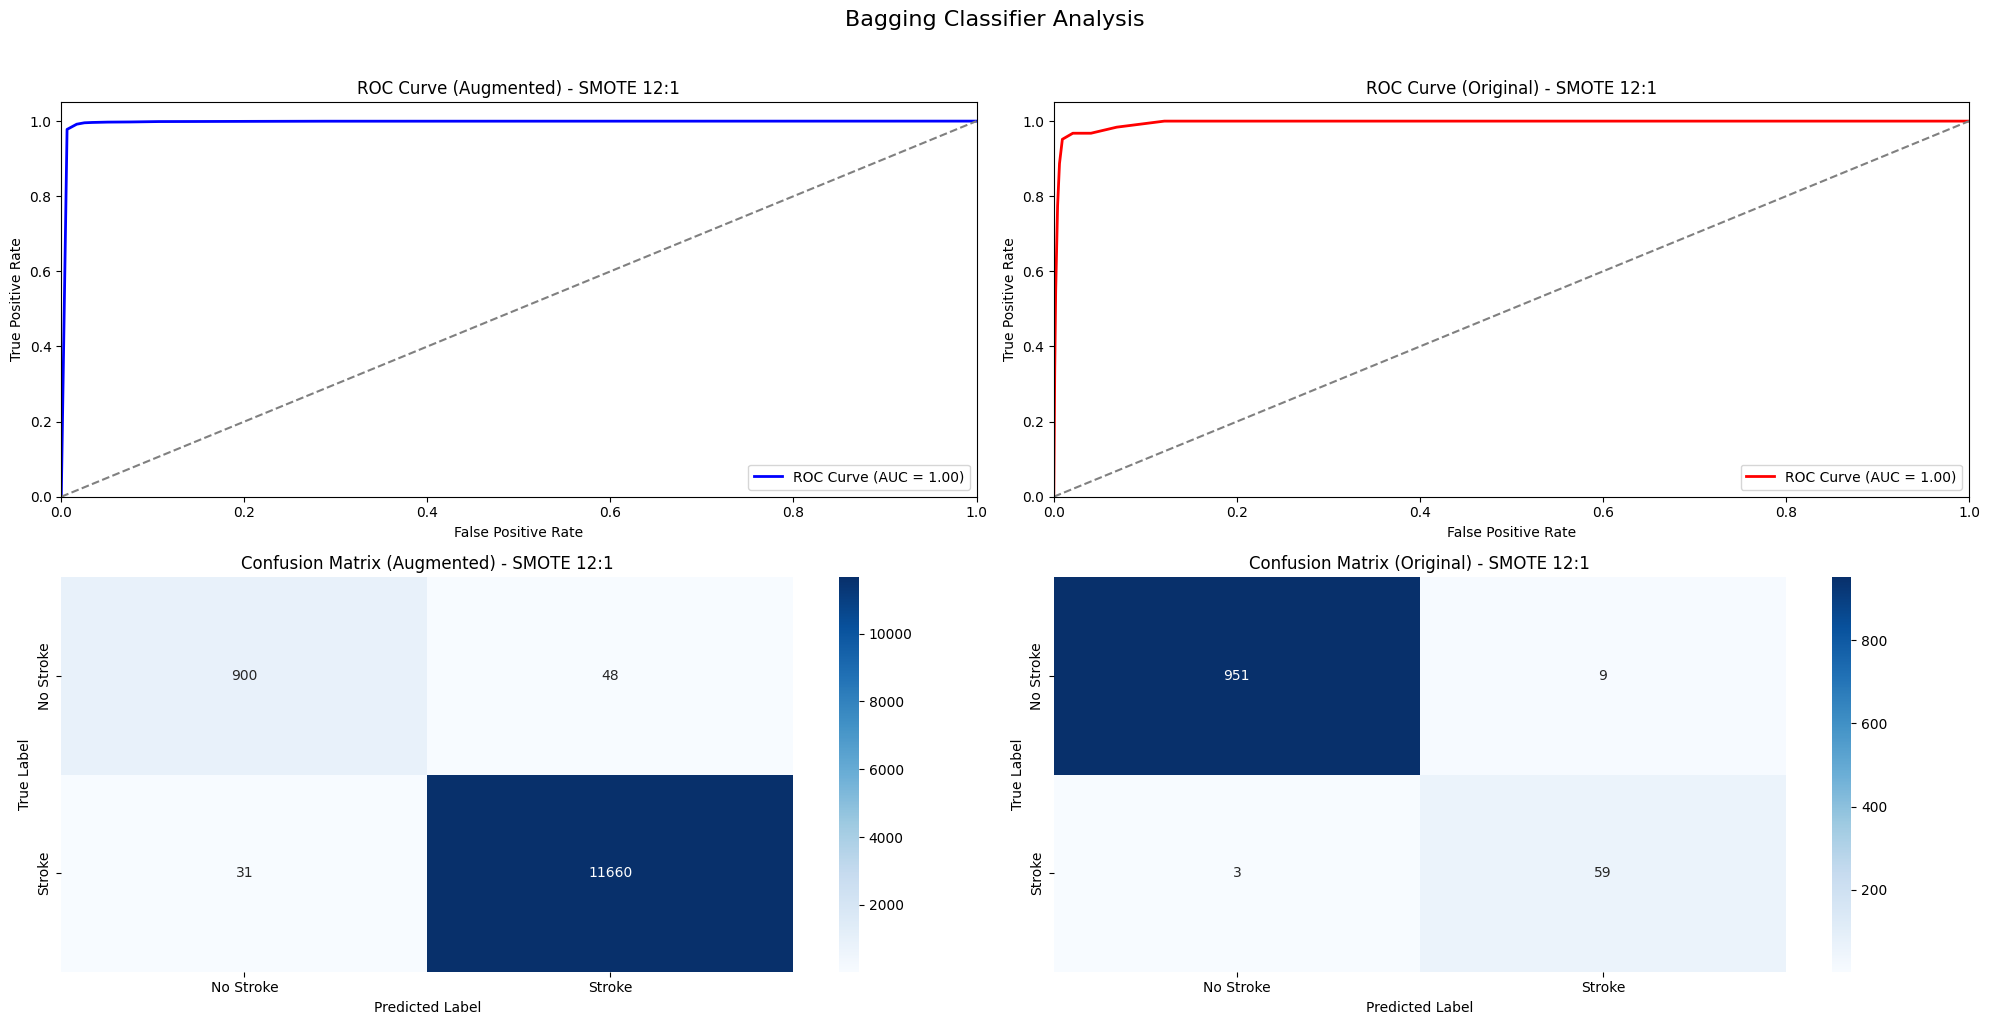


Augmented Test Data:
Accuracy: 0.9937495054988528
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96       948
           1       1.00      1.00      1.00     11691

    accuracy                           0.99     12639
   macro avg       0.98      0.97      0.98     12639
weighted avg       0.99      0.99      0.99     12639


Original Test Data:
Accuracy: 0.9882583170254403
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       960
           1       0.87      0.95      0.91        62

    accuracy                           0.99      1022
   macro avg       0.93      0.97      0.95      1022
weighted avg       0.99      0.99      0.99      1022




Analyzing Random Forest with SMOTE ratio 11:1


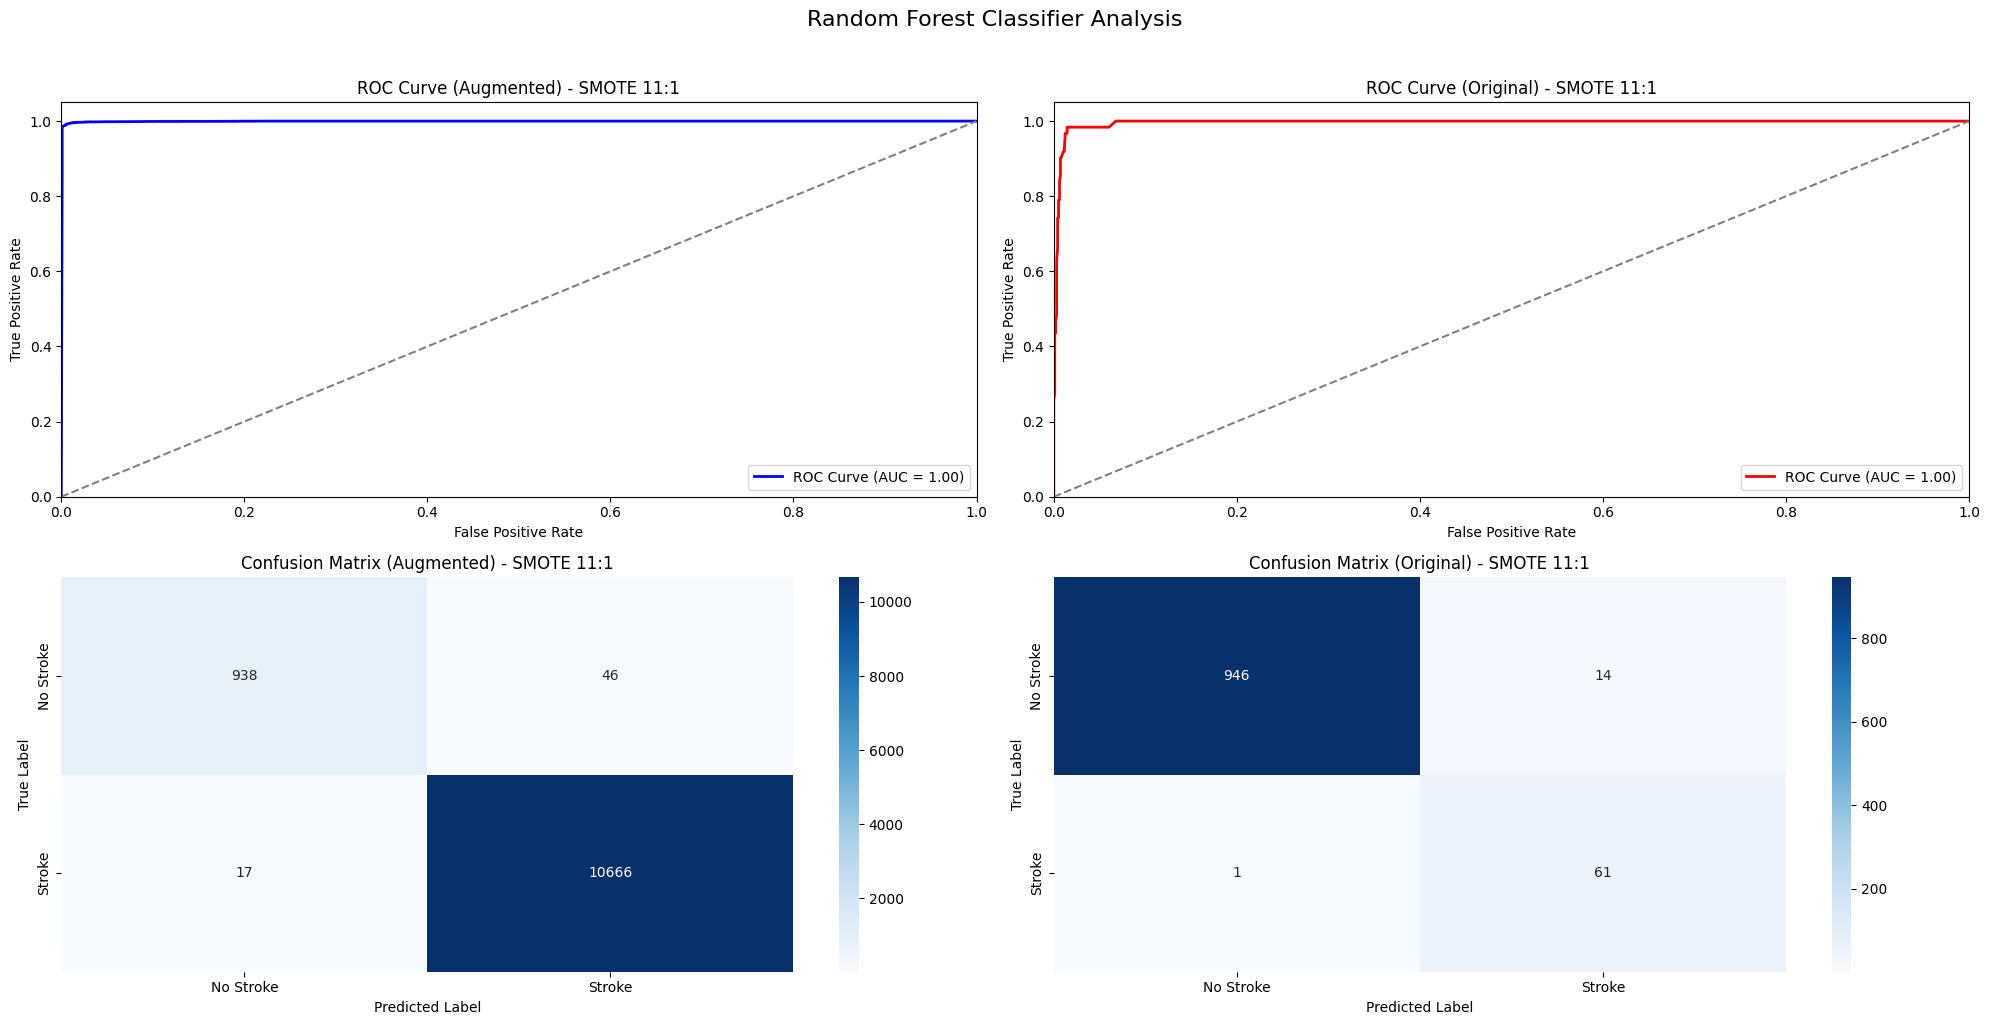


Augmented Test Data:
Accuracy: 0.9946001542813062
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.97       984
           1       1.00      1.00      1.00     10683

    accuracy                           0.99     11667
   macro avg       0.99      0.98      0.98     11667
weighted avg       0.99      0.99      0.99     11667


Original Test Data:
Accuracy: 0.9853228962818004
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       960
           1       0.81      0.98      0.89        62

    accuracy                           0.99      1022
   macro avg       0.91      0.98      0.94      1022
weighted avg       0.99      0.99      0.99      1022




Analyzing Decision Tree with SMOTE ratio 11:1


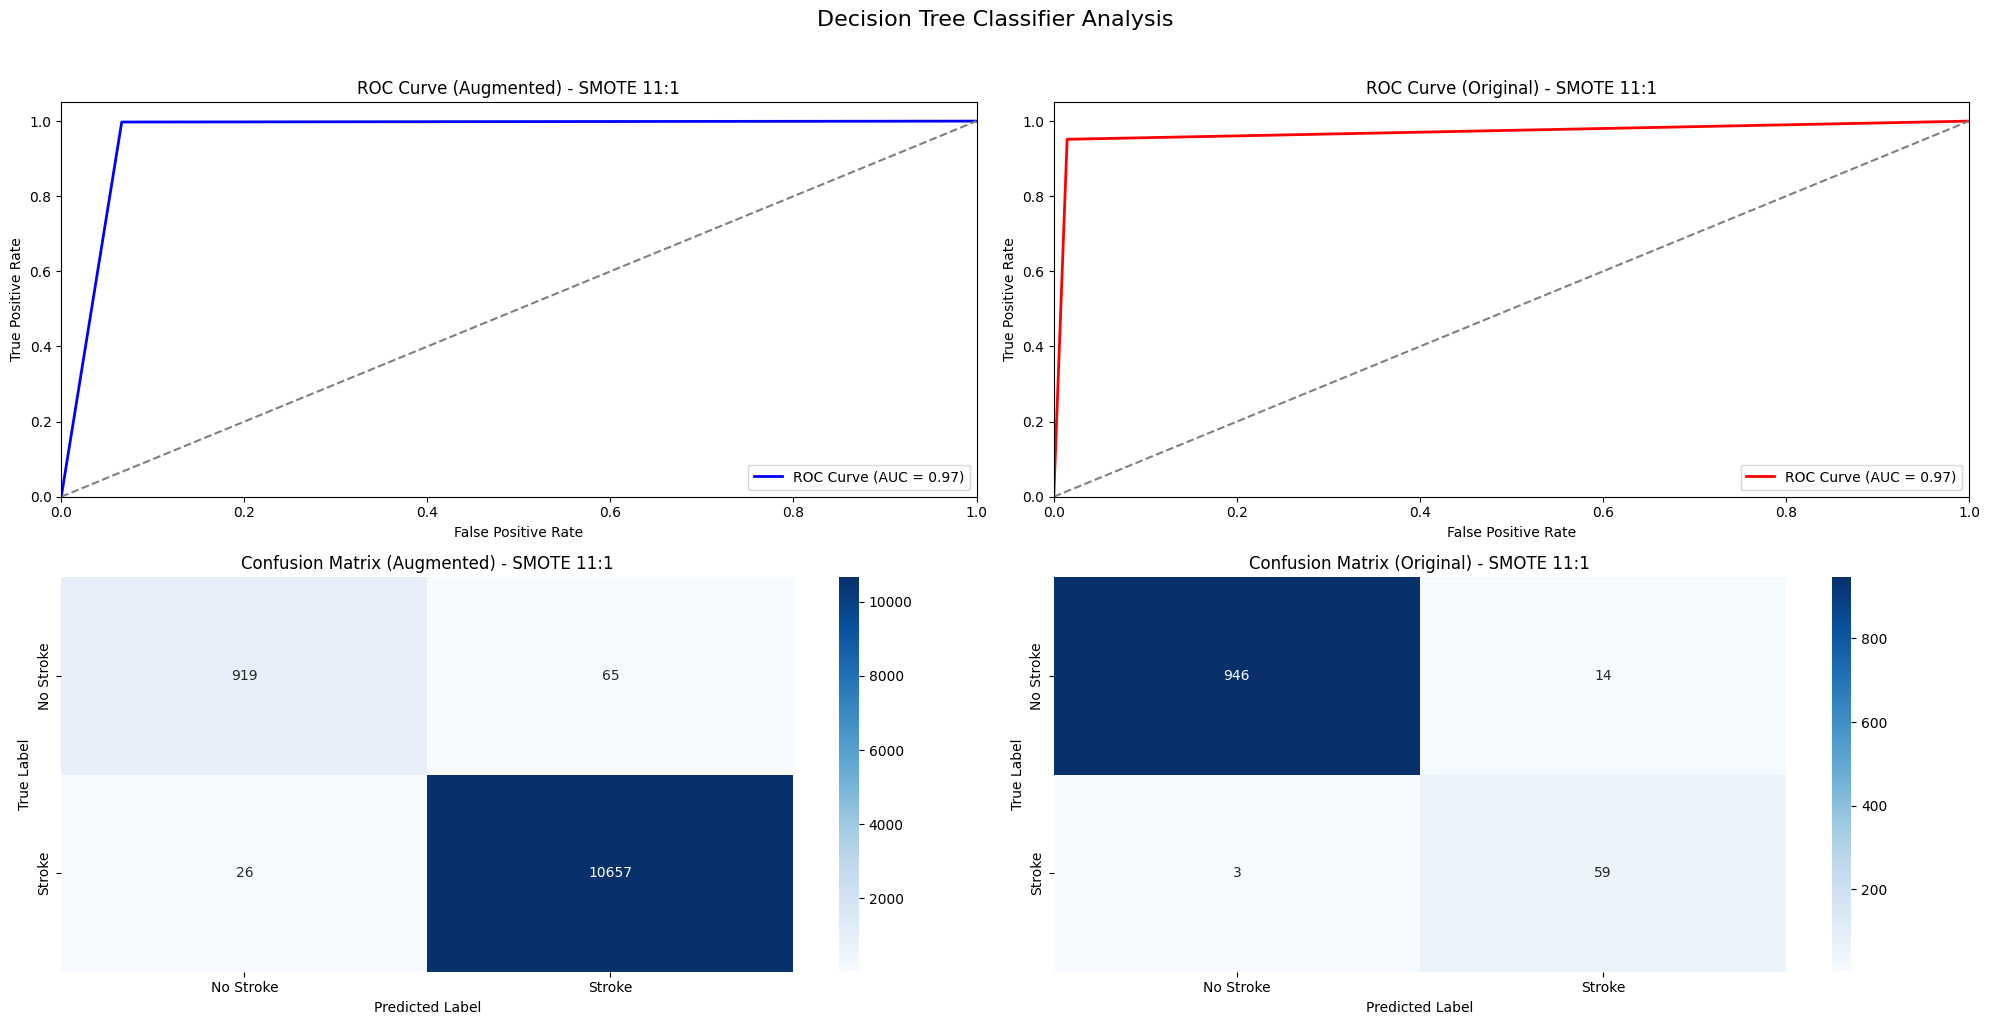


Augmented Test Data:
Accuracy: 0.9922002228507757
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.93      0.95       984
           1       0.99      1.00      1.00     10683

    accuracy                           0.99     11667
   macro avg       0.98      0.97      0.97     11667
weighted avg       0.99      0.99      0.99     11667


Original Test Data:
Accuracy: 0.9833659491193738
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       960
           1       0.81      0.95      0.87        62

    accuracy                           0.98      1022
   macro avg       0.90      0.97      0.93      1022
weighted avg       0.99      0.98      0.98      1022




Analyzing SVM with SMOTE ratio 1:1


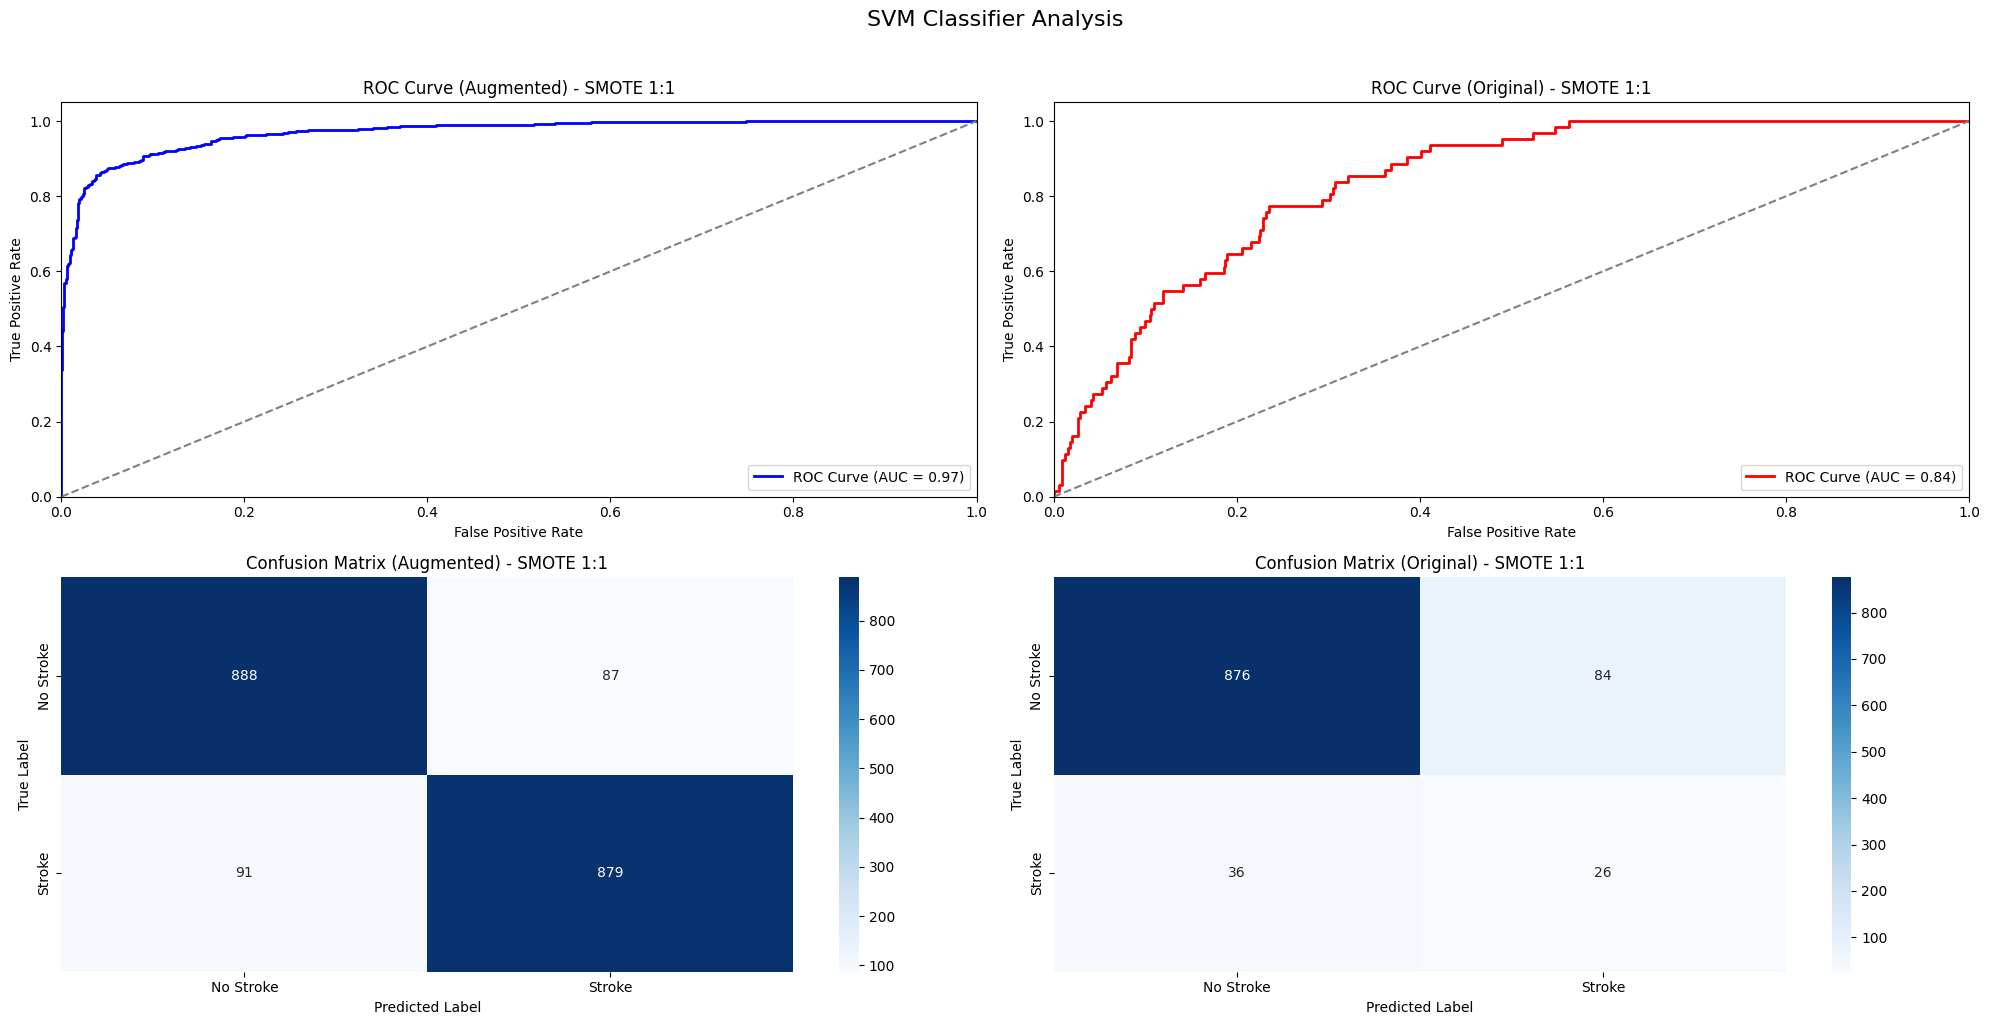


Augmented Test Data:
Accuracy: 0.9084832904884319
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91       975
           1       0.91      0.91      0.91       970

    accuracy                           0.91      1945
   macro avg       0.91      0.91      0.91      1945
weighted avg       0.91      0.91      0.91      1945


Original Test Data:
Accuracy: 0.8825831702544031
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.91      0.94       960
           1       0.24      0.42      0.30        62

    accuracy                           0.88      1022
   macro avg       0.60      0.67      0.62      1022
weighted avg       0.92      0.88      0.90      1022




Analyzing AdaBoost with SMOTE ratio 1:1


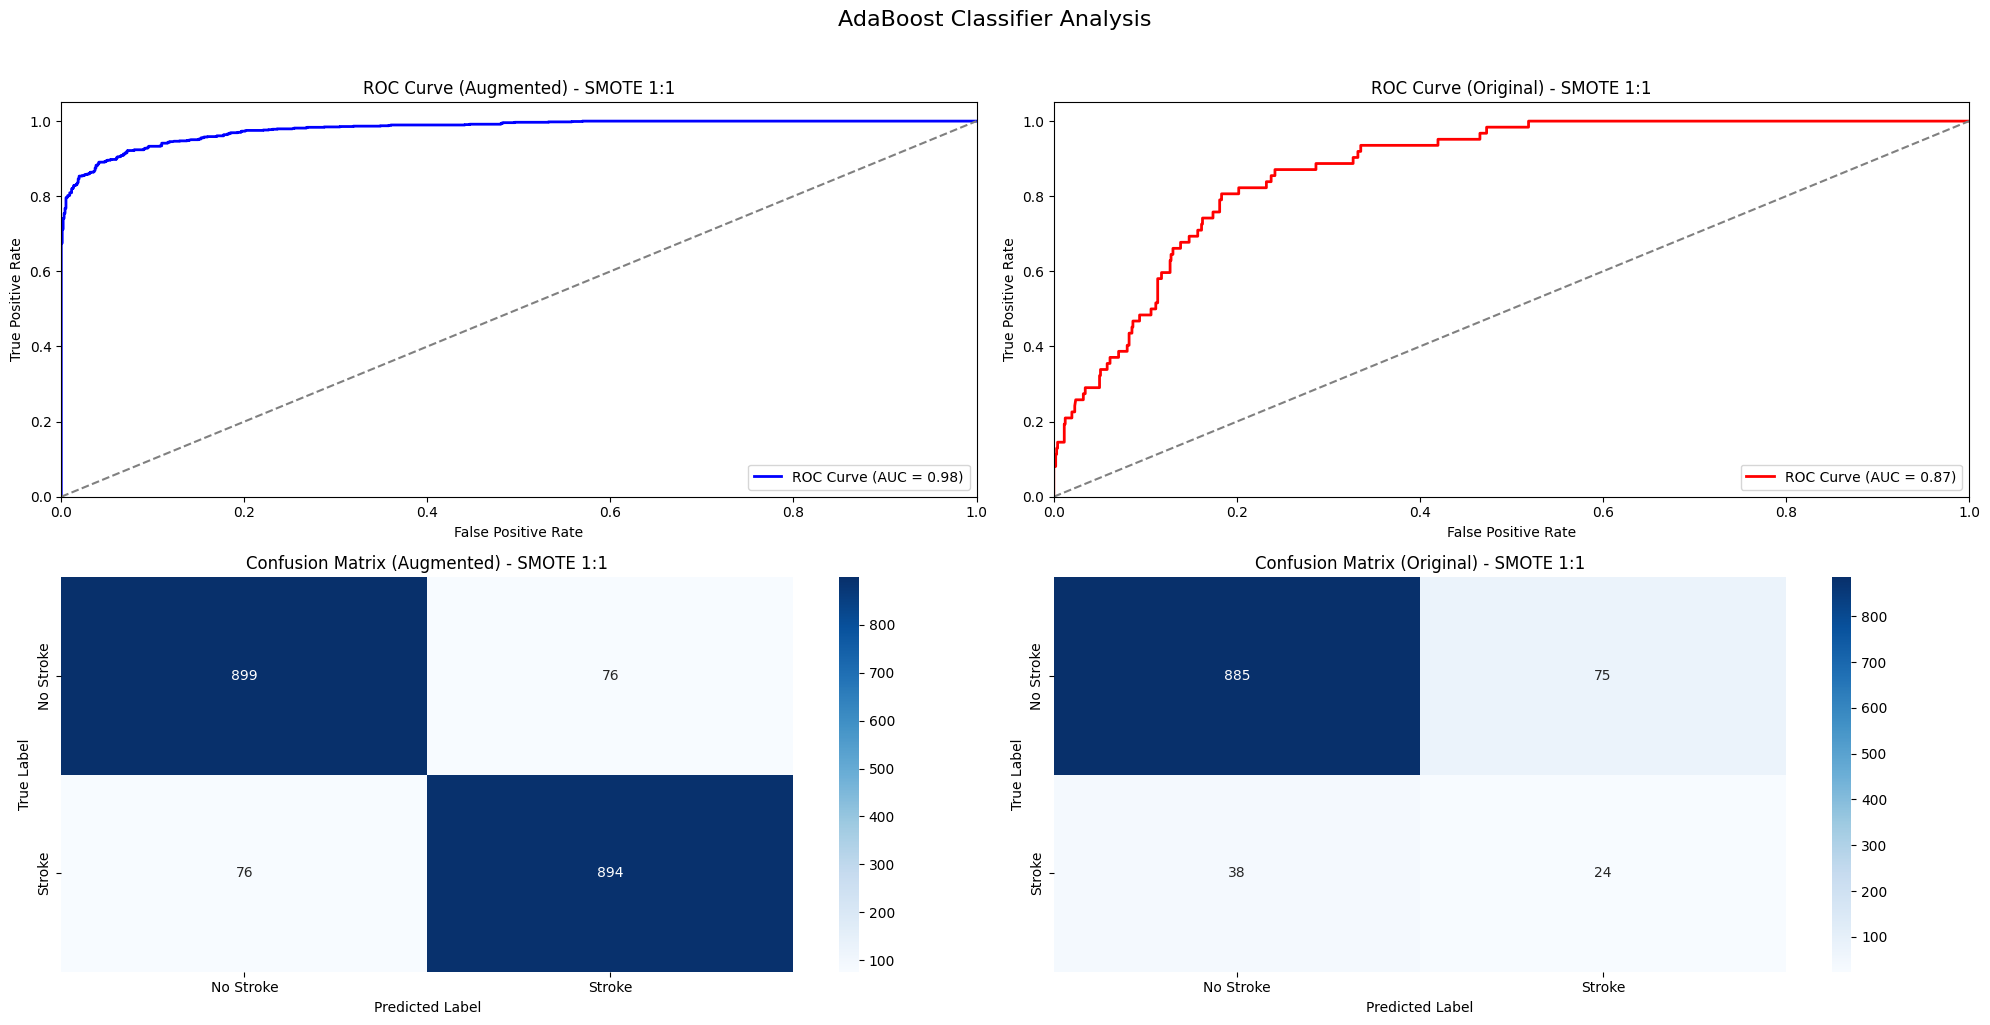


Augmented Test Data:
Accuracy: 0.9218508997429306
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.92      0.92       975
           1       0.92      0.92      0.92       970

    accuracy                           0.92      1945
   macro avg       0.92      0.92      0.92      1945
weighted avg       0.92      0.92      0.92      1945


Original Test Data:
Accuracy: 0.8894324853228963
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.92      0.94       960
           1       0.24      0.39      0.30        62

    accuracy                           0.89      1022
   macro avg       0.60      0.65      0.62      1022
weighted avg       0.92      0.89      0.90      1022




Analyzing Naive Bayes with SMOTE ratio 1:1


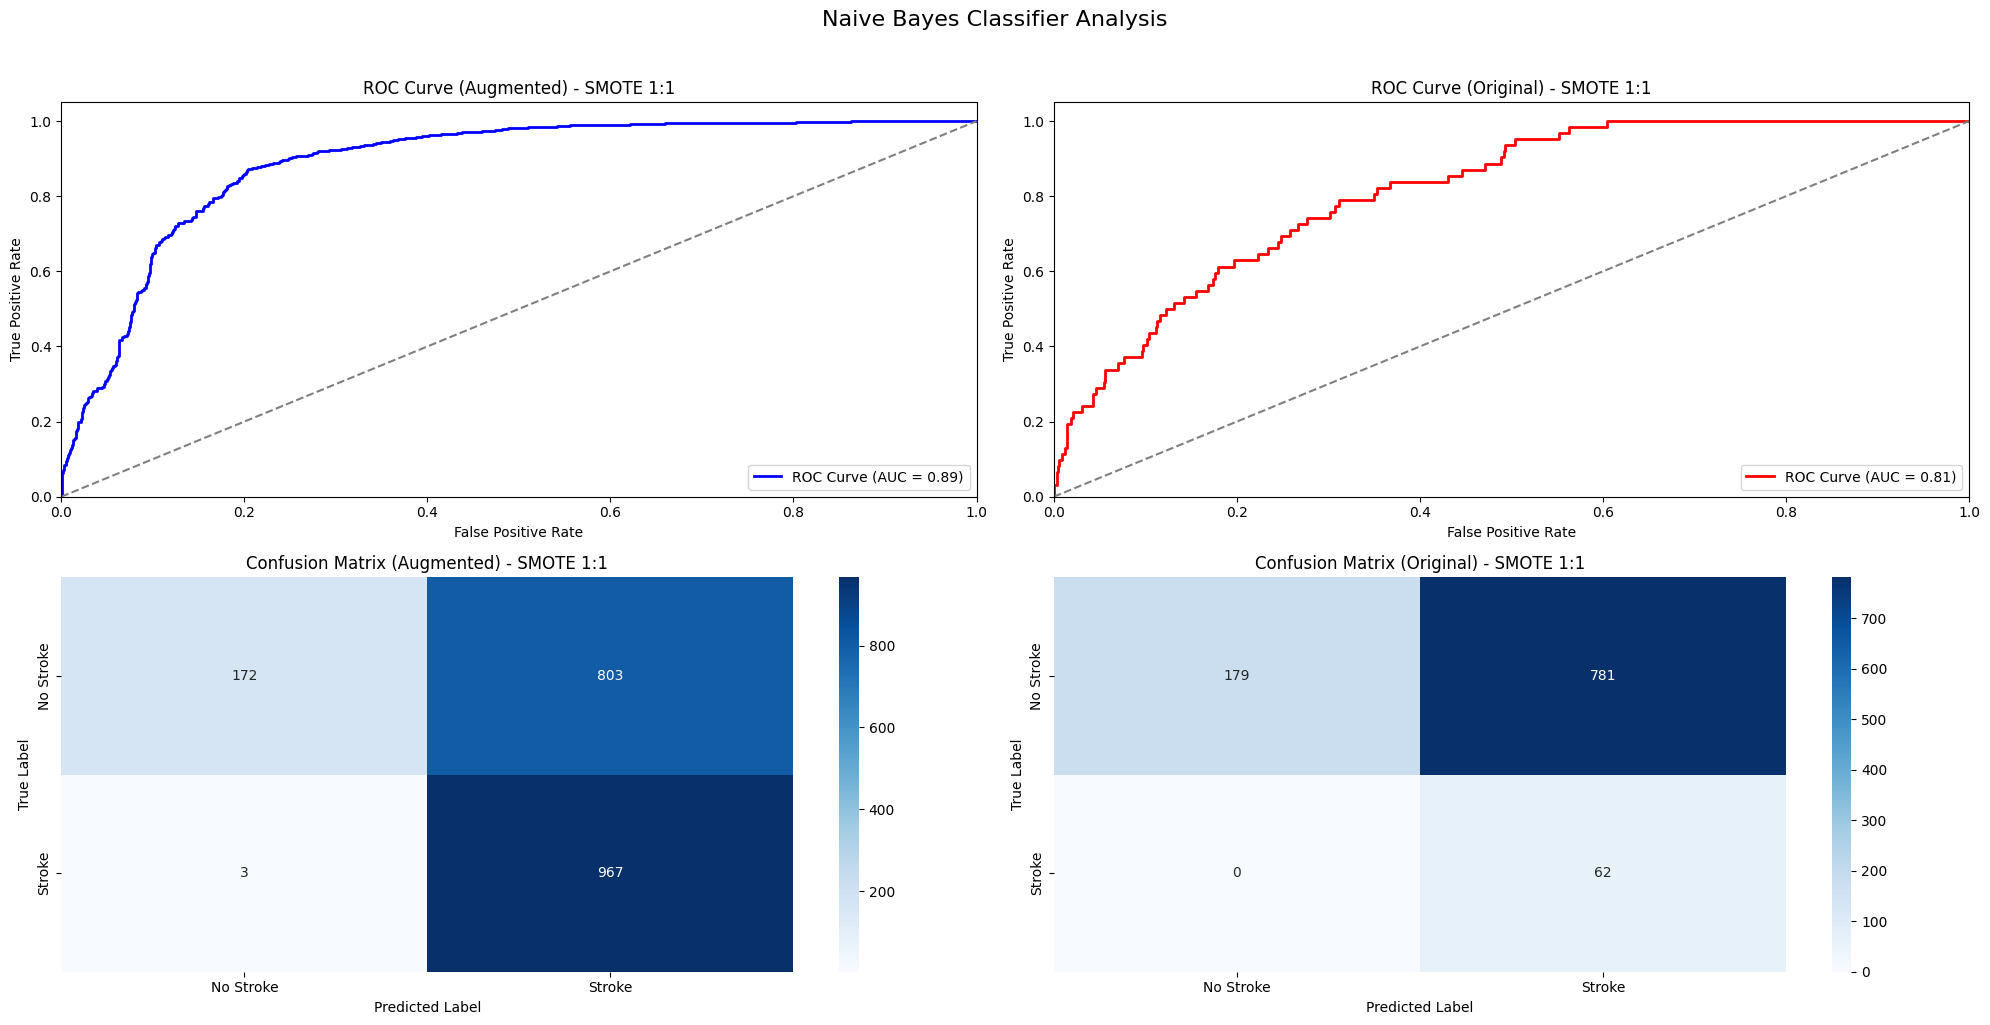


Augmented Test Data:
Accuracy: 0.5856041131105398
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.18      0.30       975
           1       0.55      1.00      0.71       970

    accuracy                           0.59      1945
   macro avg       0.76      0.59      0.50      1945
weighted avg       0.77      0.59      0.50      1945


Original Test Data:
Accuracy: 0.23581213307240703
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.19      0.31       960
           1       0.07      1.00      0.14        62

    accuracy                           0.24      1022
   macro avg       0.54      0.59      0.23      1022
weighted avg       0.94      0.24      0.30      1022




Analyzing Logistic Regression with SMOTE ratio 1:1


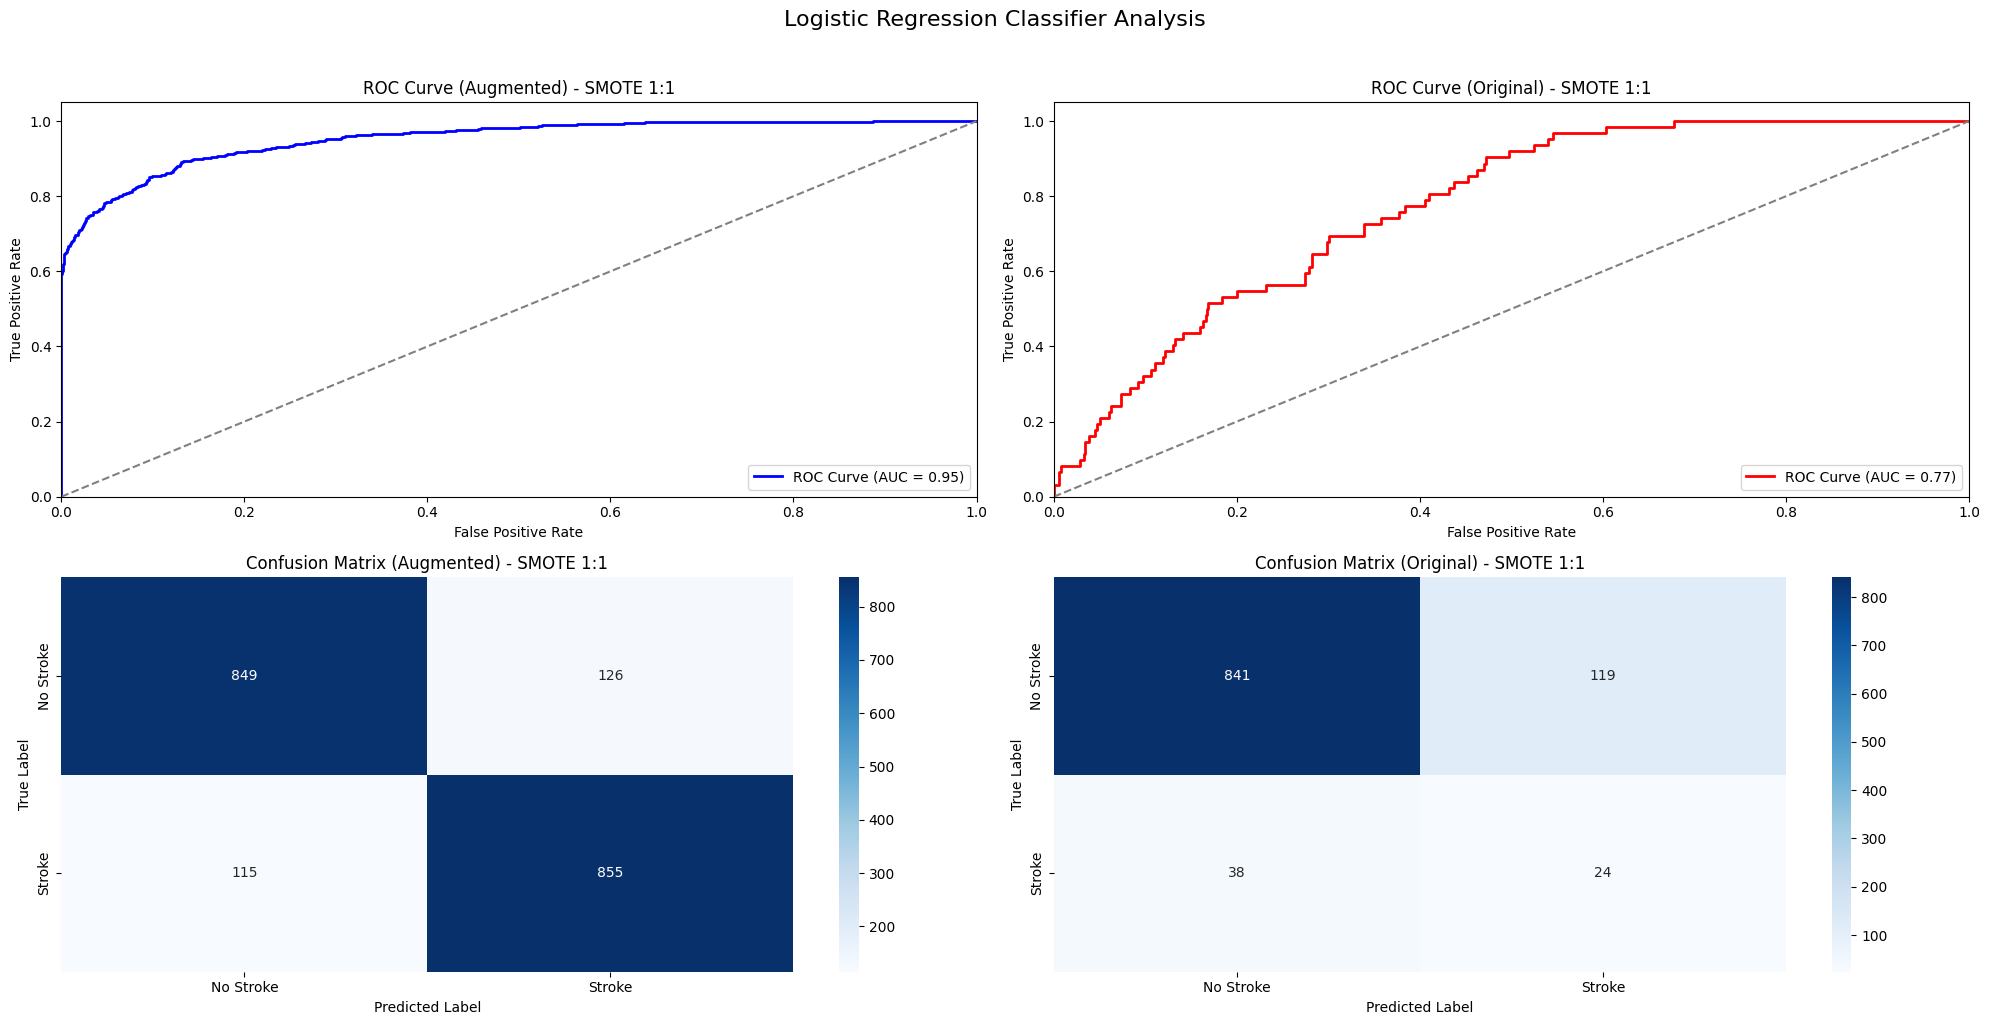


Augmented Test Data:
Accuracy: 0.8760925449871465
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.87      0.88       975
           1       0.87      0.88      0.88       970

    accuracy                           0.88      1945
   macro avg       0.88      0.88      0.88      1945
weighted avg       0.88      0.88      0.88      1945


Original Test Data:
Accuracy: 0.8463796477495108
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.88      0.91       960
           1       0.17      0.39      0.23        62

    accuracy                           0.85      1022
   macro avg       0.56      0.63      0.57      1022
weighted avg       0.91      0.85      0.87      1022





In [6]:
# 4. Test models according to their best-fit SMOTE ratio
# Dictionary to store results
results = {}

for name, config in classifier_configs.items():
    print(f"\n{'='*50}")
    print(f"Analyzing {name} with SMOTE ratio {config['smote_ratio']}:1")
    print(f"{'='*50}")
    
    # Apply SMOTE with classifier-specific ratio
    smote = SMOTE(sampling_strategy={0: len(y[y==0]), 1: config['smote_ratio']*len(y[y==0])}, random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    
    # Split and scale data
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_test_original_scaled = scaler.transform(X_test_original)
    
    # Train model
    classifier = config['model']
    classifier.fit(X_train, y_train)
    
    # Make predictions
    y_pred = classifier.predict(X_test)
    y_pred_original = classifier.predict(X_test_original_scaled)
    
    # Calculate metrics
    results[name] = {
        'augmented': {
            'accuracy': accuracy_score(y_test, y_pred),
            'conf_matrix': confusion_matrix(y_test, y_pred),
            'class_report': classification_report(y_test, y_pred)
        },
        'original': {
            'accuracy': accuracy_score(y_test_original, y_pred_original),
            'conf_matrix': confusion_matrix(y_test_original, y_pred_original),
            'class_report': classification_report(y_test_original, y_pred_original)
        }
    }
    
    # Create a figure for this classifier's visualizations
    plt.figure(figsize=(20, 10))
    
    # ROC curves
    # Augmented data ROC
    plt.subplot(2, 2, 1)
    y_pred_prob = classifier.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='blue', lw=2,
             label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve (Augmented) - SMOTE {config["smote_ratio"]}:1')
    plt.legend(loc="lower right")
    
    # Original data ROC
    plt.subplot(2, 2, 2)
    y_pred_prob_original = classifier.predict_proba(X_test_original_scaled)[:, 1]
    fpr_orig, tpr_orig, _ = roc_curve(y_test_original, y_pred_prob_original)
    roc_auc_orig = auc(fpr_orig, tpr_orig)
    plt.plot(fpr_orig, tpr_orig, color='red', lw=2,
             label=f'ROC Curve (AUC = {roc_auc_orig:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve (Original) - SMOTE {config["smote_ratio"]}:1')
    plt.legend(loc="lower right")
    
    # Confusion Matrices
    plt.subplot(2, 2, 3)
    sns.heatmap(results[name]['augmented']['conf_matrix'],
                annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Stroke', 'Stroke'],
                yticklabels=['No Stroke', 'Stroke'])
    plt.title(f'Confusion Matrix (Augmented) - SMOTE {config["smote_ratio"]}:1')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    plt.subplot(2, 2, 4)
    sns.heatmap(results[name]['original']['conf_matrix'],
                annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Stroke', 'Stroke'],
                yticklabels=['No Stroke', 'Stroke'])
    plt.title(f'Confusion Matrix (Original) - SMOTE {config["smote_ratio"]}:1')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    plt.suptitle(f"{name} Classifier Analysis", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Print metrics for this classifier
    print("\nAugmented Test Data:")
    print(f"Accuracy: {results[name]['augmented']['accuracy']}")
    print("Classification Report:\n", results[name]['augmented']['class_report'])
    
    print("\nOriginal Test Data:")
    print(f"Accuracy: {results[name]['original']['accuracy']}")
    print("Classification Report:\n", results[name]['original']['class_report'])
    print("\n")

#### Analysis and Conclusions based on results using the best-fit SMOTE ratio

Based on the results from using the best-fit SMOTE ratios across our tested models, we found the following results:
1) **KNN** (ratio 14:1):
   - accuracy = 98.33659%
   - f1 score = 0.87
2) **Bagging** (ratio 12:1):
   - accuracy = 98.82583%
   - f1 score = 0.91
3) **Random Forest** (ratio 11:1):
   - accuracy = 98.53228%
   - f1 score = 0.89
4) **Decision Tree** (ratio 11:1):
   - accuracy = 98.33659%
   - f1 score = 0.87
5) **SVM** (ratio 1:1):
    - accuracy = 88.25831%
    - f1 score = 0.30
6) **AdaBoost** (ratio 1:1):
    - accuracy = 88.94324%
    - f1 score = 0.30
7) **Naive Bayes** (ratio 1:1):
    - accuracy = 23.58121%
    - f1 score = 0.14
8) **Logistic Regression** (ratio 1:1):
    - accuracy = 84.63796%
    - f1 score = 0.23

From these findings, we found Bagging to be the best classifier for our purposes, with an accuracy of 98.83% and f1 score of 0.91. Bagging had the highest resulting accuracy and f1 score across all models, with Random Forest, KNN, and Decision Tree all attaining similar but slighlty worse results. An additional observation is that the Random Forest classifier only resulted in 1 false negative result while maintaining a high accuracy of 98.53%. No other classifier was able to achieve this low amount of false negatives while maintaining a high accuracy.